# Class Function bender class with multiple methods defined 

In [22]:
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import os
import glob

In [23]:
class bender_class:  
    
    def __init__(self, data):
        
        # Ensure data is a pandas DataFrame
        if not isinstance(data, pd.DataFrame):
            raise TypeError("Expected 'data' to be a pandas DataFrame.")
        
        self.data = data #dataframe containing data from all csv files analyzed -> m rows by 4 columns
        self.acc = None  #accuracy from quadratic curve fitting class method:  quadriatic_fit(self)
        self.model = None  # To store the trained model
        self.poly_features = None  # To store polynomial features
        
    def __str__(self):
        """
        human-readable, or informal, string representation of object
        """
        return (f"Bender Class: \n"
            f"  Number of data points: {self.data.shape[0] if self.data is not None else 0}\n"
            f"  Number of features: {self.data.shape[1] if self.data is not None else 0}\n"
            f"  Current Accuracy: {self.acc:.2f}% if self.acc is not None else 'N/A'\n")
    
    def __repr__(self):
         """
        more information-rich, or official, string representation of an object
        """
        return (f"Bender_class(data={self.data.head() if self.data is not None else 'None'}, "
            f"acc={self.acc}, "
            f"model={self.model.__class__.__name__ if self.model else 'None'}, "
            f"poly_features={self.poly_features.__class__.__name__ if self.poly_features else 'None'})")
    
    def read_data(self, path):
        """
        NOT USED IN LATEST ANALYSIS:  class method to extract all csv files in path and concatenate data in pandas dataframe
        class method also normalizes ADC around 0 and converts rotary encoder angle to deg, then 
        shifts angles to start at 0 deg
        """
        
        # use glob to get all the csv files
        # in the folder
        csv_files = glob.glob(path)
        
        if not isinstance(path, str):
            raise TypeError("Expected 'path' to be a string.")
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in the specified path: {path}")
        
        # Initialize an empty list to hold the DataFrames
        dataframes = []

        # loop over the list of csv files
        for f in csv_files:
                  
            try:
                # Read the csv file
                df = pd.read_csv(f)
            except Exception as e:
                print(f"Error reading {f}: {e}")
                continue
            
            # Check if the DataFrame has exactly 4 columns
            if df.shape[1] != 4:
                raise ValueError(f"Error: The file {f} does not contain exactly 4 columns. It has {df.shape[1]} columns.")
            
            # Remove rows where the first column equals 100
            df = df[df.iloc[:, 0] != 100]
            df = df[df.iloc[:, 1] < 95]
            
            # center ADC values around 0 (normalize ADC values)
            #df.iloc[:, 2] = (df.iloc[:, 2] - df.iloc[1, 2]) / df.iloc[1, 2]

            
            #Changes made 10/14/2024:  Normalization of data from 0 -> 1:  
            #https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
            
            y = df.iloc[:, 2].values #returns a numpy array
            y = y.reshape(-1, 1)
            # Initialize the MinMaxScaler
            min_max_scaler = preprocessing.MinMaxScaler()
            # Fit and transform the data
            y_scaled = min_max_scaler.fit_transform(y)
            # Update the DataFrame with scaled values
            df.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
                
            #convert rotary encoder to angle (deg) -> ADC is arduino Uno 10 bit
            df.iloc[:, 3] = df.iloc[:, 3] * 320 / 1024

            #shift rotary encoder angles to start tests at 0 deg
            df.iloc[:, 3] = df.iloc[:, 3] - df.iloc[1, 3]

            

            # Append the DataFrame to the list
            dataframes.append(df)
            
         # Concatenate all DataFrames in the list into a single DataFrame
        self.data = pd.concat(dataframes, ignore_index=True)
        
        return self.data
    
    def read_data_norm(self, path):
        """
        Delta R / R_o  method: extracts all csv files in path and concatenate data in pandas dataframe
        class method also normalizes ADC around 0 and converts rotary encoder angle to deg, then 
        shifts angles to start at 0 deg
        """
    
        # use glob to get all the csv files in the folder
        csv_files = glob.glob(path)
    
        if not isinstance(path, str):
            raise TypeError("Expected 'path' to be a string.")
        if not csv_files:
            raise FileNotFoundError(f"No CSV files found in the specified path: {path}")
    
        # Initialize an empty list to hold the DataFrames
        dataframes = []

        # loop over the list of csv files
        for f in csv_files:
              
            try:
                # Read the csv file
                df = pd.read_csv(f)
            except Exception as e:
                print(f"Error reading {f}: {e}")
                continue
        
            # Check if the DataFrame has exactly 4 columns
            if df.shape[1] != 4:
                raise ValueError(f"Error: The file {f} does not contain exactly 4 columns. It has {df.shape[1]} columns.")
        
            # Remove rows where the first column equals 100
            df = df[df.iloc[:, 0] != 100]
       
                
        
            df = df[df.iloc[:, 1] > -93]
            # Ensure slopes are positive
            df.iloc[:, 2] = df.iloc[:, 2].abs()
        
            # Normalize column 2
            y = df.iloc[:, 2].values # Returns a numpy array
            min_value = np.min(y)  # Find the smallest value in column 2
            y_change = (y - min_value) / min_value  # Calculate relative change from the smallest value
        
            # Update the DataFrame with the calculated change
            df.iloc[:, 2] = y_change  # Replace original values with relative change
        
            # Convert rotary encoder to angle (deg)
            df.iloc[:, 3] = df.iloc[:, 3] * 320 / 1024

            # Shift rotary encoder angles to start tests at 0 deg
            df.iloc[:, 3] = df.iloc[:, 3] - df.iloc[1, 3]

            # Append the DataFrame to the list
            dataframes.append(df)
    
        # Concatenate all DataFrames in the list into a single DataFrame
        self.data = pd.concat(dataframes, ignore_index=True)
    
        # Plot the change in column 2 over the smallest value
        #plt.plot(self.data.iloc[:, 3], self.data.iloc[:, 2], marker='o', label='Change in Column 2')
        #plt.xlabel('Rotary Encoder Angle (deg)')
        #plt.ylabel('$\Delta R/R_o$')
        #plt.legend()
        #plt.grid()
        #plt.show()
    
        return self.data
    
    def read_data_2(self, path):
        """
        MinMax normalization method:  Method extracts all csv files in path and concatenate data in pandas dataframe.
        Y-axis data range from 0 to 1, converts rotary encoder angle to degrees.  Data also drops NaN rows and has the potential to get rid of 
        very extreme data points (looks like a handful in each dataset)!
        """

        # Use glob to get all the csv files in the folder
        csv_files = glob.glob(path)
        print(f"Found {len(csv_files)} CSV files.")  # Debug statement
    
        # Initialize an empty list to hold the DataFrames
        dataframes = []

        # Loop over the list of csv files
        for f in csv_files:
            df = pd.read_csv(f)
        
            # Remove rows where the first column equals 100
            df = df[df.iloc[:, 0] != 100]
            
                    
            # Remove rows with any NaN values
            df = df.dropna()
        
            # center ADC values around 0 (normalize ADC values)
            #df.iloc[:, 2] = (df.iloc[:, 2] - df.iloc[15, 2]) / df.iloc[1, 2]
        
             # Ensure slopes are positive
            df.iloc[:, 2] = df.iloc[:, 2].abs()
            
            #Changes made 10/14/2024:  Normalization of data from 0 -> 1:  
            #https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.MinMaxScaler.html
            
            y = df.iloc[:, 2].values #returns a numpy array
            y = y.reshape(-1, 1)
            # Initialize the MinMaxScaler
            min_max_scaler = preprocessing.MinMaxScaler()
            # Fit and transform the data
            y_scaled = min_max_scaler.fit_transform(y)
            # Update the DataFrame with scaled values
            df.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
                
        
            # Convert rotary encoder to angle (degrees) -> ADC is Arduino Uno 10 bit
            df.iloc[:, 3] = df.iloc[:, 3] * 320 / 1024
        
            # Shift rotary encoder angles to start tests at 0 degrees
            initial_angle = df.iloc[20, 3]  # Save initial angle for later adjustment
            df.iloc[:, 3] = df.iloc[:, 3] - initial_angle 
            df = df[df.iloc[:, 3] > -93]
                 
            # Append the DataFrame to the list
            dataframes.append(df)

        # Concatenate all DataFrames in the list into a single DataFrame
        self.data = pd.concat(dataframes, ignore_index=True)

        return self.data
    
    
    
    def plot_data(self):
        """
        class method to plot normalized ADC values vs Rotary Encoder angles (blue dots) AND IMU angles (red dots)
        """
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
        
        # Plotting Rotary Encoder data
        plt.plot(-1 * self.data.iloc[:, 3], self.data.iloc[:, 2], 'bo', label='Rotary Encoder')  # Blue circles for Rotary Encoder
        
        
        # Plotting IMU data
        #plt.plot(-1 * self.data.iloc[:, 1], self.data.iloc[:, 2], 'ro', label='IMU')  # Red circles for IMU
        #plt.yscale("log")
        #plt.xscale("log")
        
        # Setting labels
        plt.xlabel('Angle (deg)')
        plt.ylabel('MinMax(ADC)')

        # Adding legend
        plt.legend()
        plt.show()
        
        return
    
    
    def model_data(self, thick, l_ch, l_sam, area, res):
        """
        Class method to plot normalized data (delta R / Ro) vs bend angle as well as theoretical curve  based on mechanics model .
        """
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")

        # Plot Rotary Encoder data
        fig, ax1 = plt.subplots()

        ax1.plot(-1 * self.data.iloc[:, 3], self.data.iloc[:, 2], 'bo', label='Rotary Encoder Data')  # Blue circles for Rotary Encoder    

        theta = np.arange(0, np.pi/2 + 0.1, 0.1)  # Include 90 by adding increment
        rho = 29.4 * 10**-8
        eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
        dr = (rho * eps * (l_ch * 0.0254) * (8 - eps) / ((area * 0.000645) * (2 - eps)**2))
        drrt = dr / res
        ax1.plot(theta * 180 / np.pi, drrt, 'g', label='Theoretical Model')  

        # Setting up bottom axis
        ax1.set_xlabel('Angle (deg)')
        ax1.set_ylabel('$\Delta R/R_o$', color='b')
        ax1.tick_params(axis='y', labelcolor='b')
        ax1.legend(loc="upper left")

         # Define 5 evenly spaced tick positions for theta
        theta_ticks = np.linspace(0, np.pi/2, 5)  # 5 points from 0 to 90 degrees in radians
        eps_ticks = (thick * 0.0254 + 0.00635) * theta_ticks / (l_sam * 0.0254)  # Compute corresponding eps values

        # Create top x-axis for eps
        ax2 = ax1.twiny()  # Twin the x-axis to share the y-axis
        ax2.set_xlim(ax1.get_xlim())  # Synchronize with bottom x-axis

        ax1.set_xticks(theta_ticks * 180 / np.pi)  # Set bottom x-axis (theta) ticks in degrees
        ax2.set_xticks(theta_ticks * 180 / np.pi)  # Match top x-axis ticks to bottom x-axis
        ax2.set_xticklabels([f"{e:.2f}" for e in eps_ticks])  # Set top x-axis labels with eps values
        ax2.set_xlabel('$\epsilon$ (strain)')

        plt.tight_layout()
        plt.show()
        
    def train_test(self, deg_accuracy):
        """
        class method to determine how well a model that predicts angle based on normalized ADC value input up to +/- deg_accuracy 
        """
        
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
            
               
        # Cross-validation (train: 80%, test: 20%)
        dataTrain, dataTest = train_test_split(self.data, test_size=0.2, random_state=None)

        # Fit a polynomial of degree X to the training data
        poly_features = PolynomialFeatures(degree=1)  # degree of 1 corresponds to linear fit, 2 would be quadratic
        X_train = -1 * dataTrain.iloc[:, 2].values.reshape(-1, 1)  # Reshapes the 1D array into a 2D array with one... 
        # column and as many rows as needed for compatibility with sklearn functions
        y_train = dataTrain.iloc[:, 3].values  # Converts Pandas Series to a NumPy array
        X_train_poly = poly_features.fit_transform(X_train)

        self.model = LinearRegression()
        self.model.fit(X_train_poly, y_train)
        self.poly_features = poly_features  # Store the polynomial features

        # Predicting using the test set
        X_test = -1 * dataTest.iloc[:, 2].values.reshape(-1, 1)  
        X_test_poly = self.poly_features.transform(X_test)
        y_test = self.model.predict(X_test_poly)

        # Accuracy determined by finding the number of test data that predicts
        # actual angle correctly to within +/- deg_accuracy
        pos = np.sum(np.abs(y_test - dataTest.iloc[:, 3].values) < deg_accuracy)  
        total = len(dataTest)

        # Calculate accuracy
        self.acc = pos * 100 / total if total > 0 else 0  # Avoid division by zero
        
         # Optionally print the accuracy
        #print(f'Accuracy: {self.acc:.2f}%')
        
        return self.acc
    
    def train_test_log(self, deg_accuracy):
        """
        Class method to determine how well a model predicts angle based on 
        normalized ADC value input up to +/- deg_accuracy using log-log fitting.
        """
    
        if self.data is None:
            raise ValueError("Data not available. Please read the data first.")
        
        # Cross-validation (train: 80%, test: 20%)
        dataTrain, dataTest = train_test_split(self.data, test_size=0.2, random_state=None)

        # Prepare the training data using log transformation
        # Ensure we add a small constant to avoid log(0)
        X_train = -1 * dataTrain.iloc[:, 3].values + 1e-10  # Normalized ADC values
        y_train = dataTrain.iloc[:, 2].values +  1e-10        # Rotary Encoder angles
        
              
        # Fit a linear model to the log-log data
        self.model = LinearRegression()
        self.model.fit(X_train.reshape(-1, 1), y_train)  # Reshape for sklearn

        # Prepare the test data for predictions
        X_test = -1 * dataTest.iloc[:, 3].values + 1e-10  # Normalized ADC values
        y_test = dataTest.iloc[:, 2].values + 1e-10        # Rotary Encoder angles
        
       

        # Apply log transformation
        #X_test_log = np.log10(X_test)
        y_test_log_pred = self.model.predict(X_test.reshape(-1, 1))

        # Convert predictions back to original scale
        y_test_pred = 10 ** y_test_log_pred

        # Accuracy determined by finding the number of test data that predicts
        # actual angle correctly to within +/- deg_accuracy
        pos = np.sum(np.abs(y_test_pred - dataTest.iloc[:, 3].values) < deg_accuracy)  
        total = len(dataTest)

        # Calculate accuracy
        self.acc = pos * 100 / total if total > 0 else 0  # Avoid division by zero
    
        return self.acc
    
    def predict_new_data(self, new_data_obj, deg_accuracy):
        """
        Uses result from trained model method from single dataset/test to make predictions on new data/test from another bender_class object
        and calculates the accuracy of those predictions based on a specified degree of accuracy. 

        :param new_data_obj: An instance of bender_class containing new data for predictions.
        :param deg_accuracy: The degree of accuracy within which the predictions are considered correct.
        :return: A float representing the accuracy of the predictions.
        """
        # Ensure that the model has been trained
        if self.model is None or self.poly_features is None:
            raise Exception("Model has not been trained yet. Please run the train_test method first.")
        
        
        # Retrieve new data
        new_data = new_data_obj.data

        # Prepare new data for prediction
        X_new = -1 * new_data.iloc[:, 2].values.reshape(-1, 1)  # Assuming the same structure
        X_new_poly = self.poly_features.transform(X_new)

        # Predict using the trained model
        y_pred_new = self.model.predict(X_new_poly)

        # Calculate accuracy based on the setpoint
        # Assuming the actual angles are in the fourth column of the new data
        actual_angles = new_data.iloc[:, 3].values
        pos = np.sum(np.abs(y_pred_new - actual_angles) < deg_accuracy)  # Count how many predictions are within the specified accuracy
        total = len(actual_angles)

        # Calculate accuracy
        accuracy = pos * 100 / total if total > 0 else 0  # Avoid division by zero

        # Optionally print the accuracy
        #print(f'Prediction Accuracy: {accuracy:.2f}%')

        # Create a DataFrame to hold the new data and the predictions
        results = pd.DataFrame(new_data)
        results['Predicted_Angle'] = y_pred_new  # Add predictions as a new column

        return accuracy, results
    
    
    
       
    

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

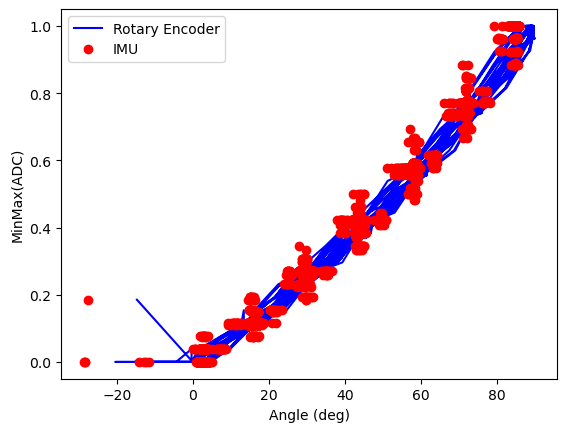

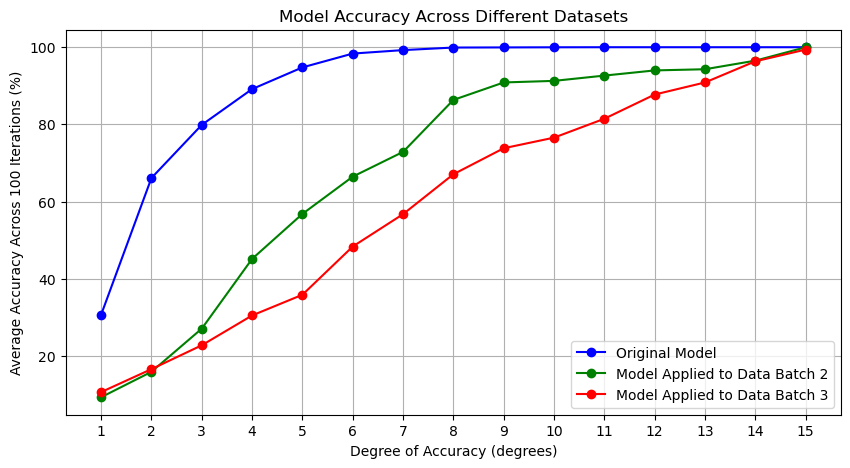

In [53]:
g = bender_class(data=pd.DataFrame())
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/*.csv"
g.read_data(path)
g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 2', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 3', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

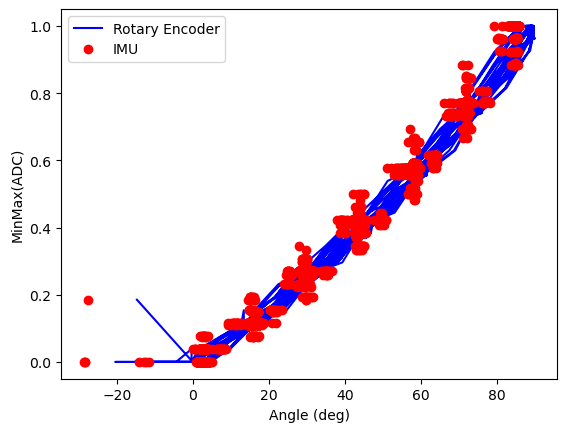

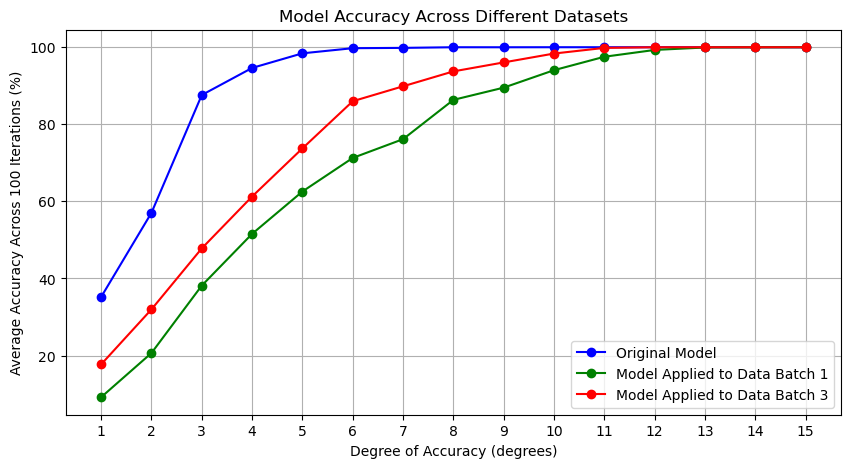

In [54]:
g = bender_class(data=pd.DataFrame())
#path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/*.csv"
g.read_data(path)
g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 1', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 3', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

# Model Fitting

The following block of code creates an object g that reads four sets of CSV files (without reapplication), constructs a pandas DataFrame, and fits a second-order polynomial model using 80% of the data for training and 20% for testing (as defined in the train_test class method). This data split is performed randomly. After fitting the model, the code plots the model's accuracy over 100 iterations.

Subsequently, the fitted model is used to assess the accuracy of two additional sets of tests, where reapplication occurred before each block of tests. 

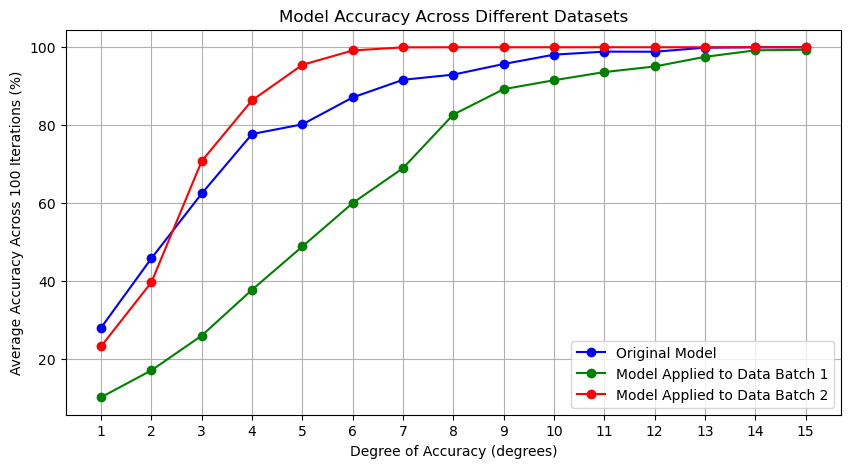

In [55]:
#g = bender_class(data=pd.DataFrame())
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
#path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/9_19_24_v1/single/*.csv"
#g.read_data(path)
#g.plot_data()
#g.quadratic_fit()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v2/*.csv"
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_17_24/*.csv"
new_g.read_data(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/9_19_24_v1/*.csv"
new_s.read_data(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')
plt.plot(degree_of_accuracies, all_accuracies_second, marker='o', label='Model Applied to Data Batch 1', color='green')
plt.plot(degree_of_accuracies, all_accuracies_third, marker='o', label='Model Applied to Data Batch 2', color='red')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()

#  Using the Wheatstone Bridge Circuit and 24-bit ADC

x64 gain and reference voltage of 2.4V
18 mV across A+ and A- measured with handheld multimeter

R1 = 101 ohms
R2 = var resistor 0 - 1 kohm (balanced to make Vout as close to 0 as possible)
Rx = 100 ohm + strain guage (0.8 ohms)
R3 = 100 ohm


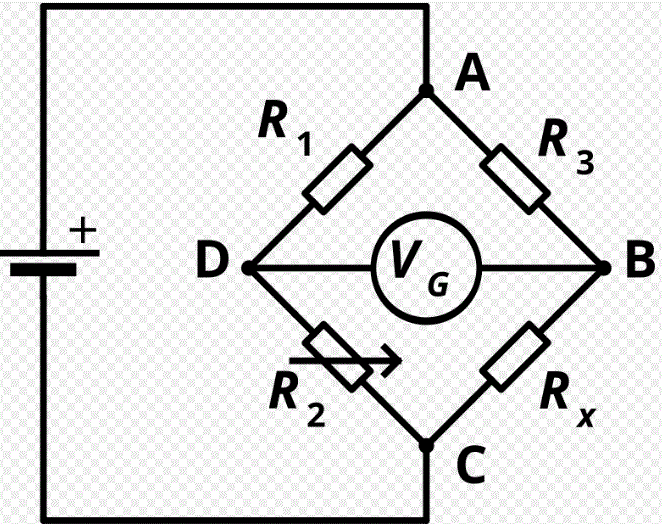

Found 1 CSV files.
97.68518518518519


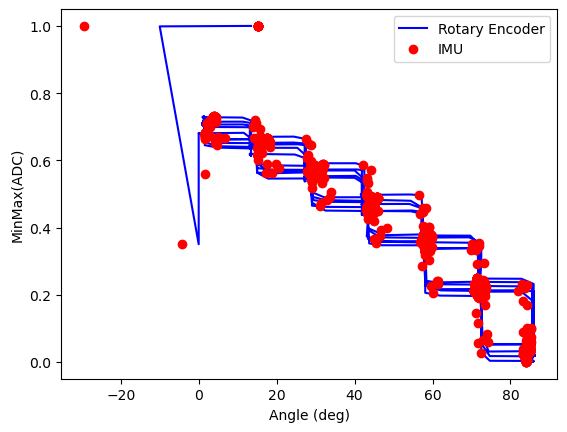

In [56]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 5 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/10_1_24/v6/*.csv"
#PLEASE NOT THERE WERE OUTLIER DATA POINTS AROUND 0 delta R over Ro WHICH WERE REMOVED!
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()


#  Using the Wheatstone Bridge Circuit and 24-bit ADC

x128 gain and reference voltage of 2.7V
5.8 mV across A+ and A- measured with handheld multimeter

Found 1 CSV files.
97.5346687211094


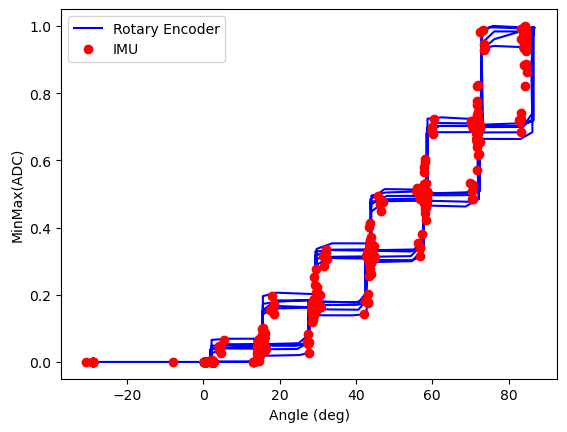

In [57]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 5 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Glove 2024/bender_code/data/10_2_24/*.csv"
#PLEASE NOT THERE WERE OUTLIER DATA POINTS AROUND 0 delta R over Ro WHICH WERE REMOVED!
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()


#  First Good Test!  Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 1 CSV files.
100.0


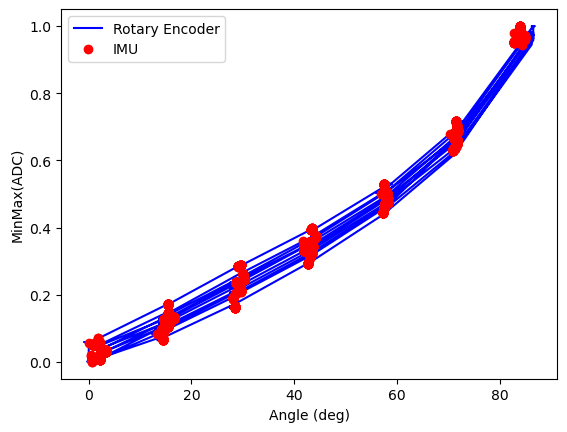

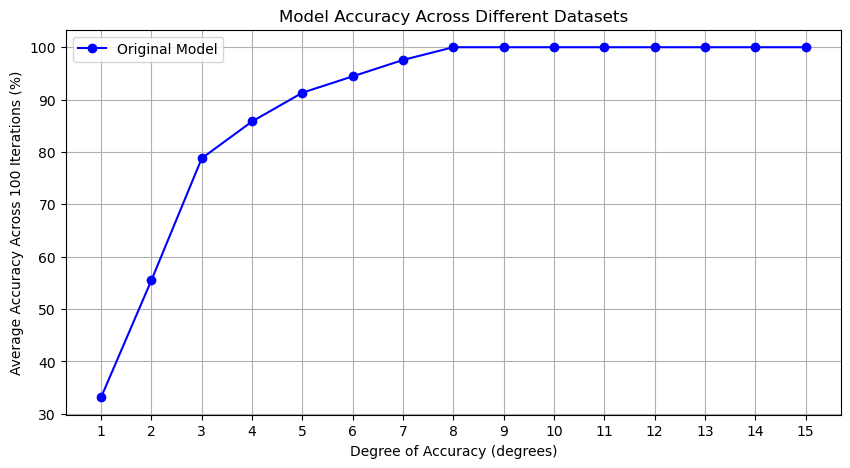

In [58]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/single data set/*.csv"
g.read_data_2(path)

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = path
g.read_data(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  8 Tests no Reapplication:  Slipping?   Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 8 CSV files.
96.58762290341238


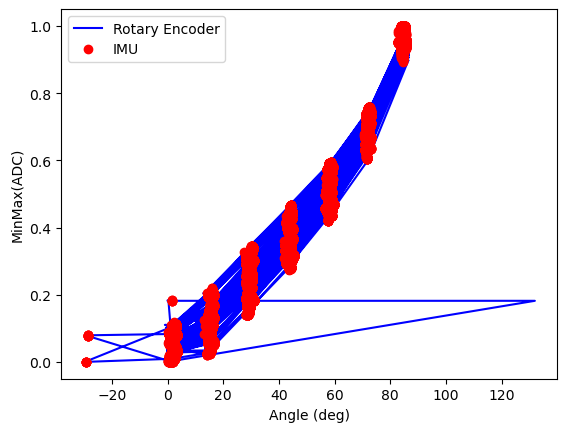

Found 8 CSV files.


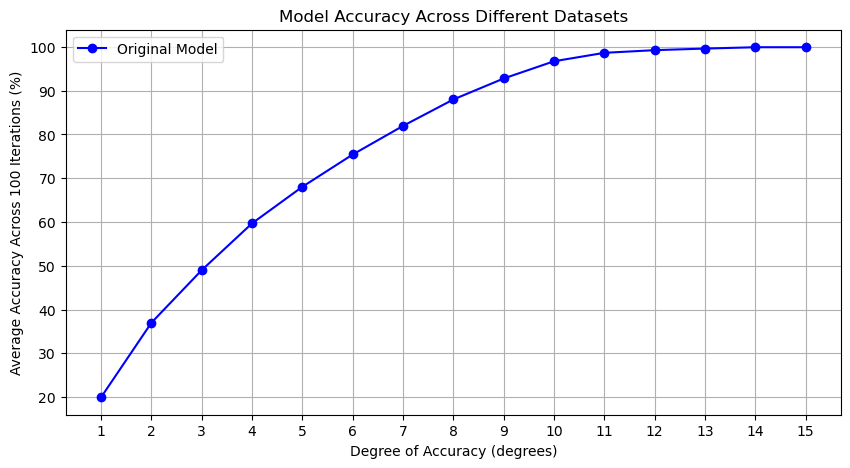

In [59]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/*.csv"
g.read_data_2(path)

# Drop NaN values from g.data after reading data
g.data = g.data.dropna()

# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/*.csv"
g.read_data_2(path_1)

# Drop NaN values from g.data after reading data
g.data = g.data.dropna()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  1 Test Reapplication:    Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 1 CSV files.


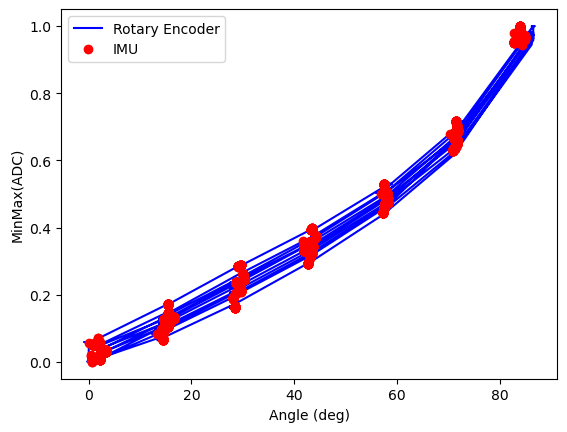

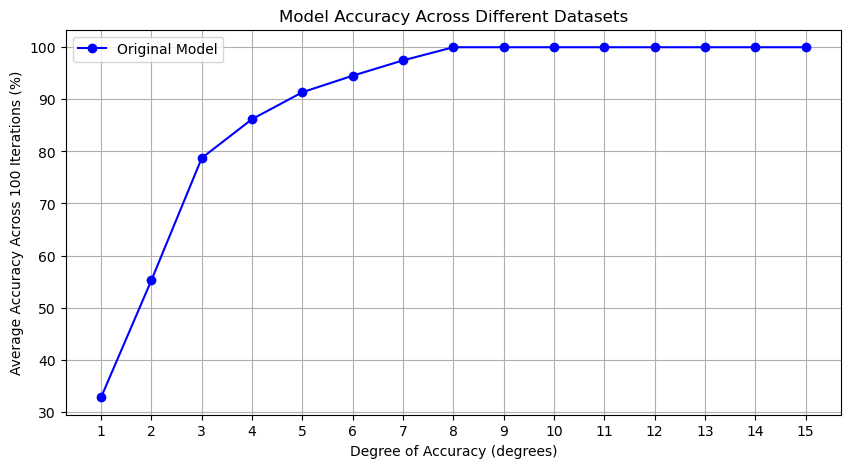

In [60]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/single data set/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
#print(accuracy)

# Plot the data with fitted results
g.plot_data()

# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = path
g.read_data(path_1)



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



#  1 Test and Last with Reapplication:    Using the Wheatstone Bridge Circuit and 24-bit ADC 

x32 or x128 gain and reference voltage of 2.7V (check excel lab notebook)
5.8 mV across A+ and A- measured with handheld multimeter

increased length delay between servo rotate and data collection from 50 ms to 1 sec

Found 2 CSV files.
100.0


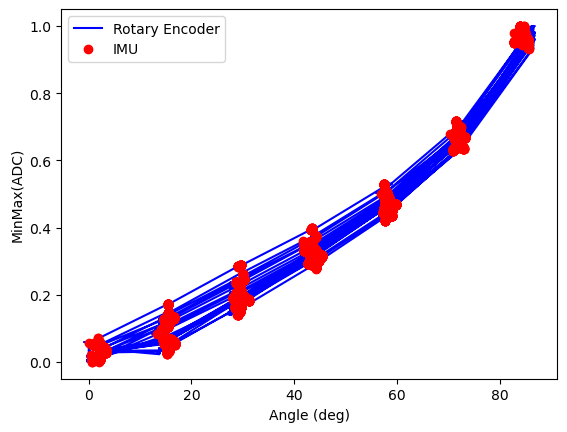

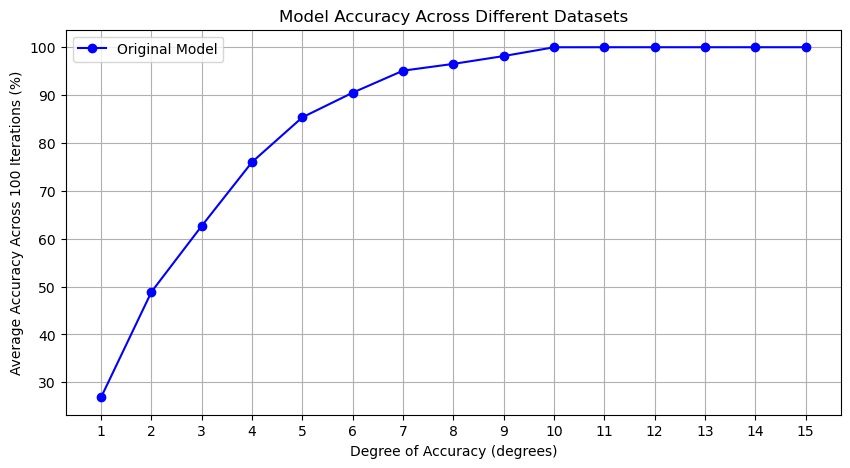

In [72]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_14_2024/v2/data no slipping/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



In [62]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_21_2024/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()


Found 2 CSV files.


IndexError: single positional indexer is out-of-bounds

In [ ]:
df = pd.read_csv('hand_collected abs_100.csv') 
da =  pd.DataFrame()
da['Column_0'] = 0  # Placeholder for the second column (you might want to replace with meaningful data)
da['Column_1'] = df.iloc[:, 1]  # fake imu angle
da['Column_2'] = df.iloc[:, 0] 
da['Column_3'] = df.iloc[:, 1] * -1 # Placeholder for the third column (you might want to replace with meaningful data
g = bender_class(data=da)
g.data.iloc[:, 1] = g.data.iloc[:, 1] * -1
# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
g.plot_data()


In [63]:
# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()



ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#  Data below taken from Flex. Print. Electron. 7 (2022) 035003   (Ivan Minev Lab)

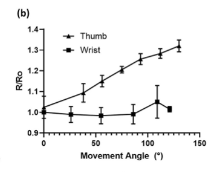


They hand subject flex thumb MCP and monitor norm. resistance as well as flex angle obtained from camera system

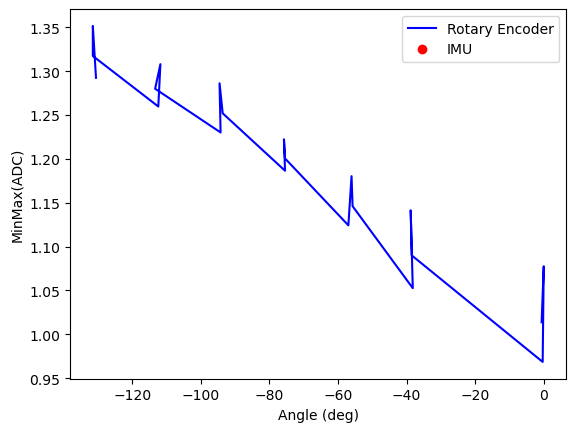

In [64]:
df = pd.read_csv('ivan minev plot data.csv') 
da =  pd.DataFrame()
da['Column_0'] = 0  # Placeholder for the second column (you might want to replace with meaningful data)
da['Column_1'] = 0  # fake imu angle
da['Column_2'] = df.iloc[:, 1] 
da['Column_3'] = df.iloc[:, 0]  # Placeholder for the third column (you might want to replace with meaningful data
g = bender_class(data=da)
g.data.iloc[:, 1] = g.data.iloc[:, 1] 
# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
g.plot_data()

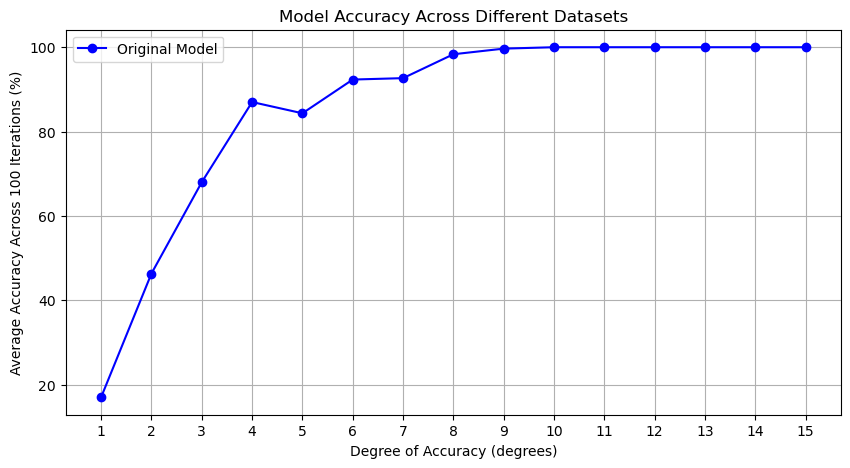

In [76]:
# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

   Column_0  Column_1  Column_2  Column_3
0       NaN -149.3750       6.5 -149.3750
1       NaN -135.3125       7.9 -135.3125
2       NaN -120.3125       9.2 -120.3125
3       NaN -105.0000      10.5 -105.0000
4       NaN  -90.9375      11.5  -90.9375


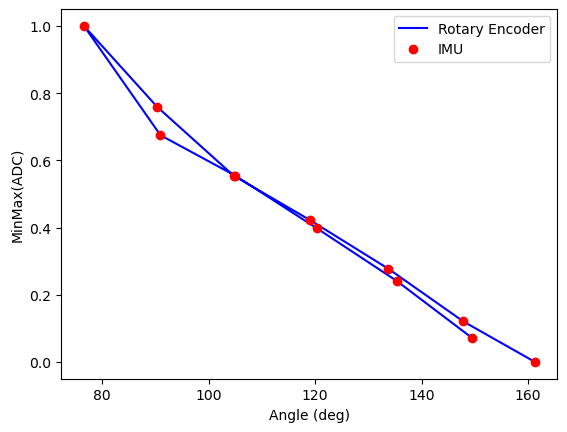

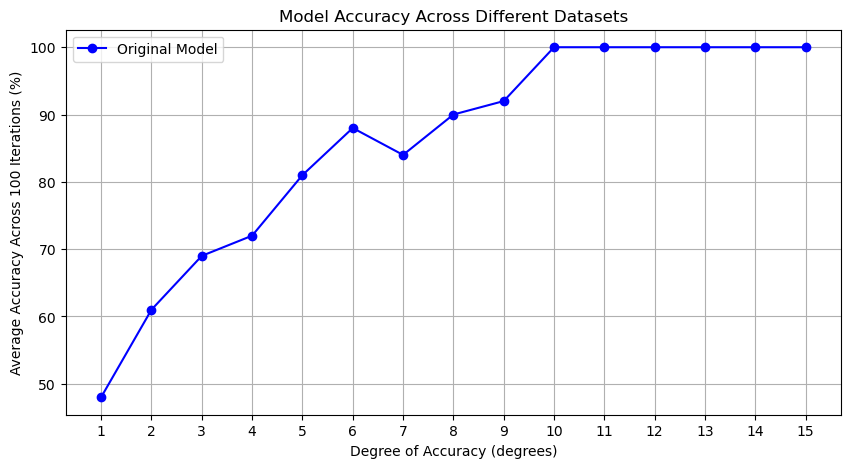

In [70]:
df = pd.read_csv('hand_collected abs_100_v2.csv') 
da =  pd.DataFrame()
da['Column_0'] = 0  # Placeholder for the second column (you might want to replace with meaningful data)
da['Column_1'] = df.iloc[:, 0] * -320 / 1024 # fake imu angle
da['Column_2'] = df.iloc[:, 1] 
da['Column_3'] = df.iloc[:, 0] * -320 / 1024 # Placeholder for the third column (you might want to replace with meaningful data
#shift rotary encoder angles to start tests at 0 deg
#da.iloc[:, 3] = da.iloc[:, 3] - da.iloc[0, 3]
print(da.head())

g = bender_class(data=da)
#g.data.iloc[:, 1] = g.data.iloc[:, 0] * 1

y = g.data.iloc[:, 2].values #returns a numpy array
y = y.reshape(-1, 1)
# Initialize the MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
# Fit and transform the data
y_scaled = min_max_scaler.fit_transform(y)
# Update the DataFrame with scaled values
g.data.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Wheatstone Bridge Circuit 

Voltage across bridge measured manually with multimeter....1 reading per bend angle

   Column_0  Column_1  Column_2  Column_3
0       NaN  -13.1250       6.9  -13.1250
1       NaN  -27.5000       8.2  -27.5000
2       NaN  -42.1875       9.5  -42.1875
3       NaN  -57.5000      10.9  -57.5000
4       NaN  -72.1875      12.6  -72.1875


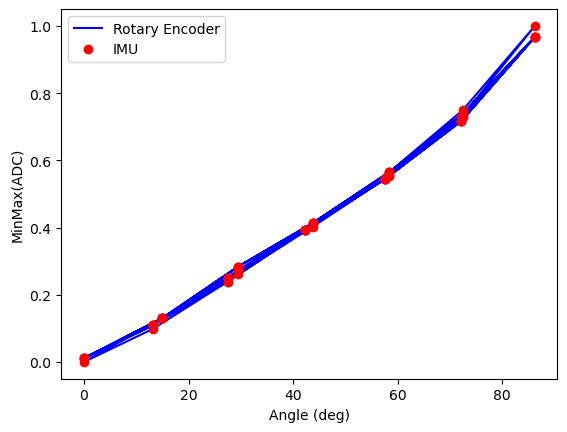

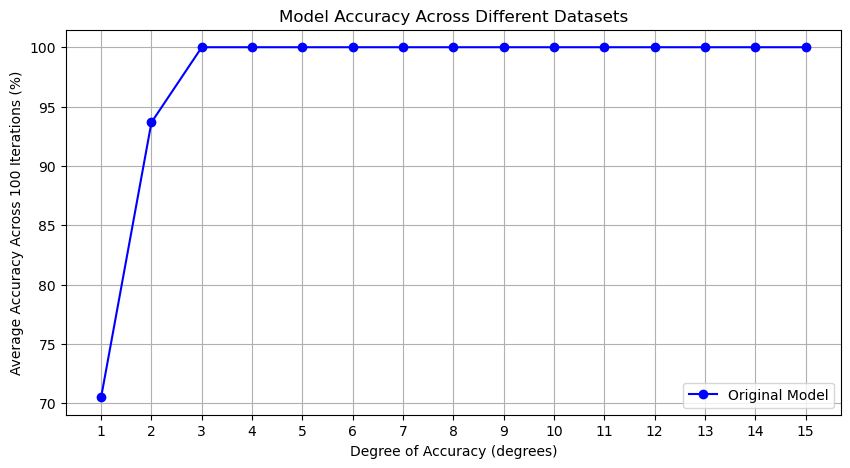

In [88]:
df = pd.read_csv('hand_collected_v5_2.csv') 
da =  pd.DataFrame()
da['Column_0'] = 0  # Placeholder for the second column (you might want to replace with meaningful data)
da['Column_1'] = df.iloc[:, 0]*320/1024 - df.iloc[-1, 0]*320/1024  # fake imu angle
da['Column_2'] = df.iloc[:, 1] 
da['Column_3'] = df.iloc[:, 0]*320/1024 - df.iloc[-1, 0]*320/1024 # Placeholder for the third column (you might want to replace with meaningful data

print(da.head())

g = bender_class(data=da)

y = g.data.iloc[:, 2].values #returns a numpy array
y = y.reshape(-1, 1)
# Initialize the MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
# Fit and transform the data
y_scaled = min_max_scaler.fit_transform(y)
# Update the DataFrame with scaled values
g.data.iloc[:, 2] = y_scaled.flatten()  # Flatten back to 1D for assignment
# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

#  Wheatstone Bridge Circuit...seems there are ADC issues

Found 1 CSV files.
29.320987654320987


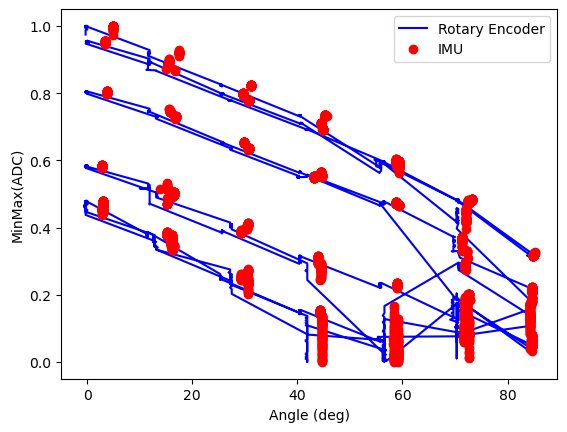

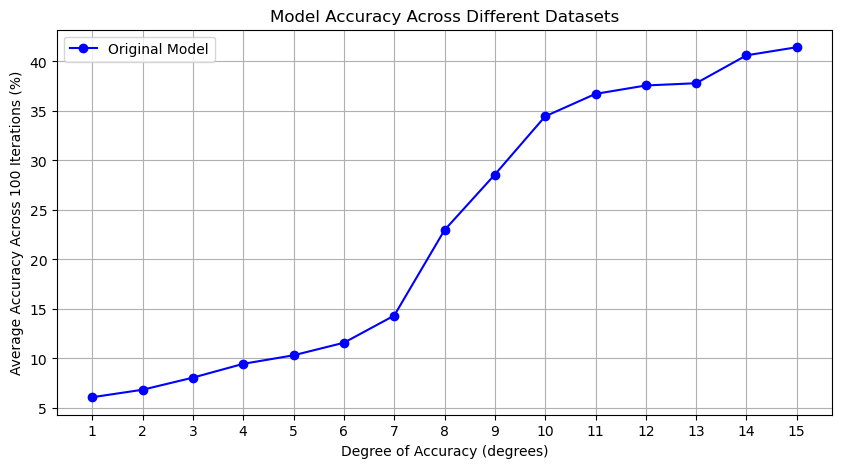

In [89]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_25_2024/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Voltage Divider Circuit since Wheatsonebridge issues...

Gain = 4x, 16 bit resolution

Found 1 CSV files.
100.0


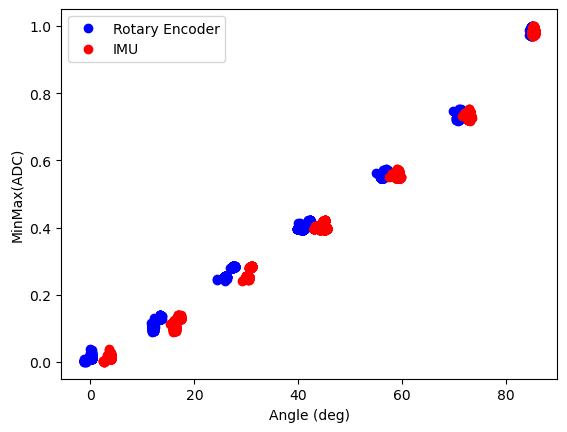

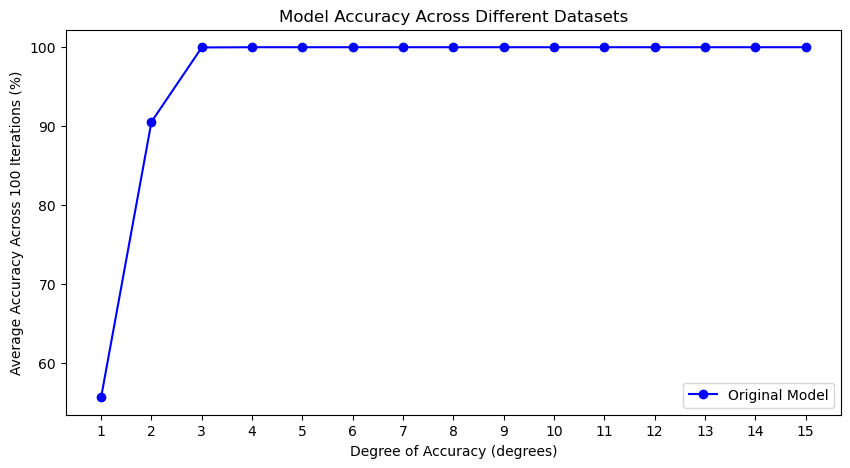

In [13]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/10_25_2024/voltage divider circuit/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets

# Osh Park Voltage Divider V1 -> bending to 90 deg

voltage divider, x4, 16 bit encoding

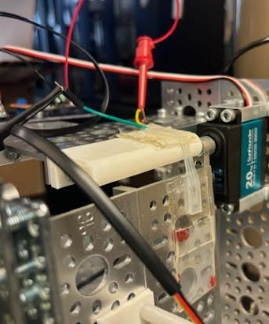

Found 1 CSV files.
72.92307692307692


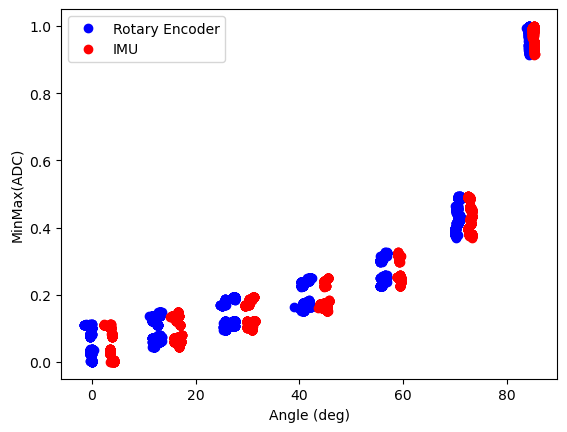

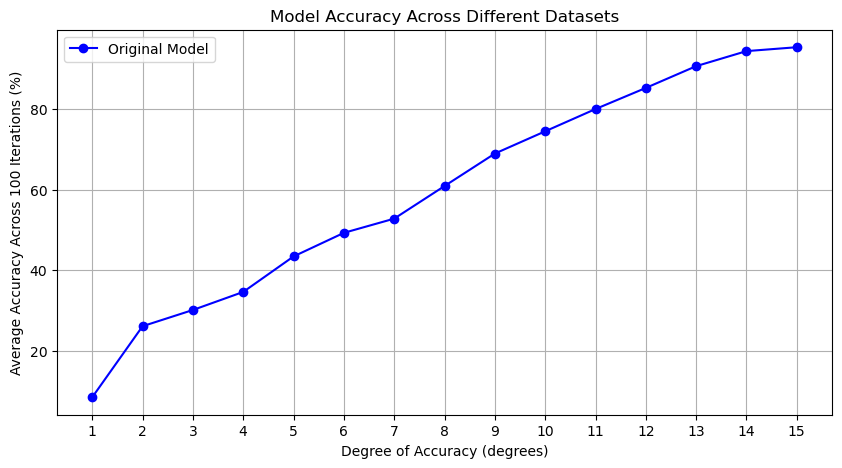

In [12]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_13_2024/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Osh Park Voltage Divider V1 -> bending to 90 deg

voltage divider, x4, 16 bit encoding

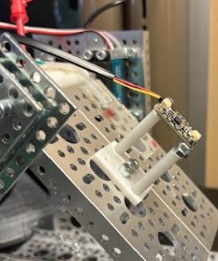

Found 1 CSV files.
100.0


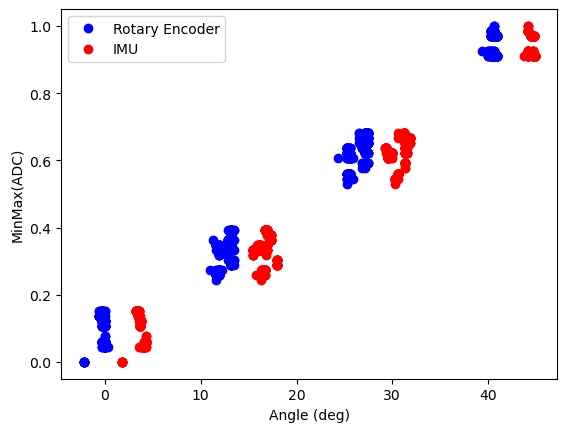

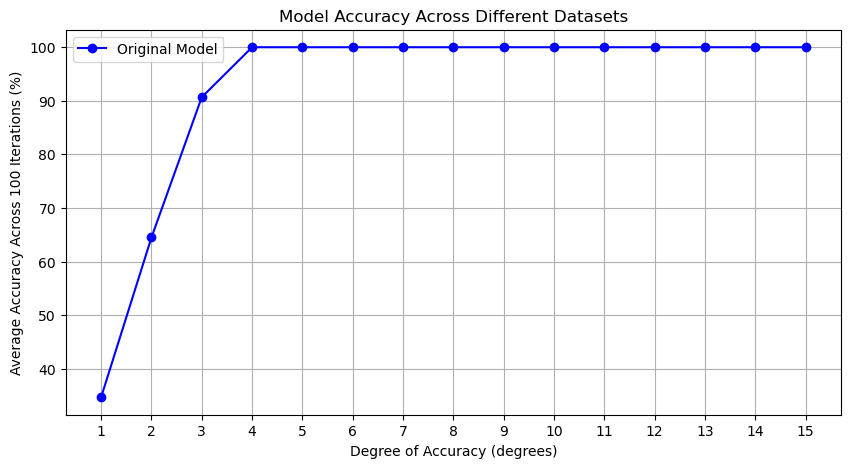

In [11]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_13_2024/45 deg bend/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Bending_data_abs_2p27_11_21_24_v2.csv

abs_2p27 -> leads not making good/consistent electrical contact with LM so original resistance jumps around.  

Leads not long enough in LM?

Found 1 CSV files.
40.92307692307692


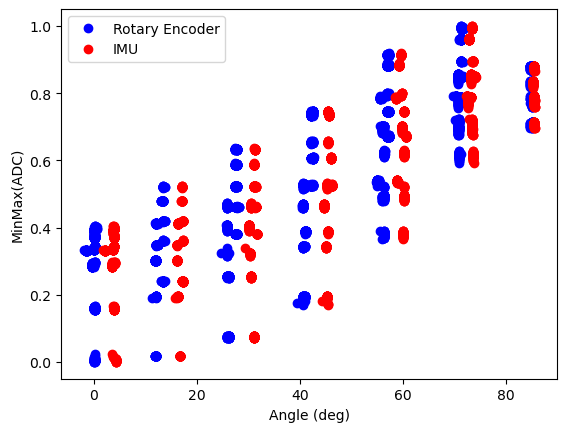

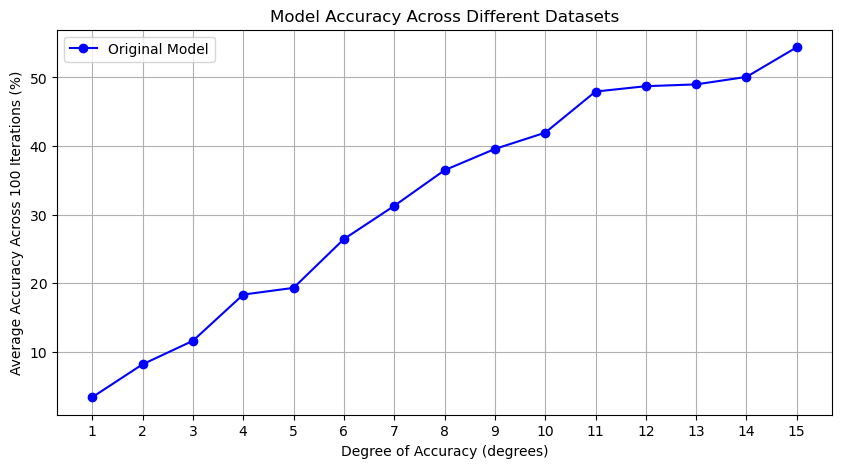

In [5]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_21_2024/v2/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Bending_data_abs_1p5_11_21_24_v1.csv

abs_1p5 

Found 1 CSV files.
100.0


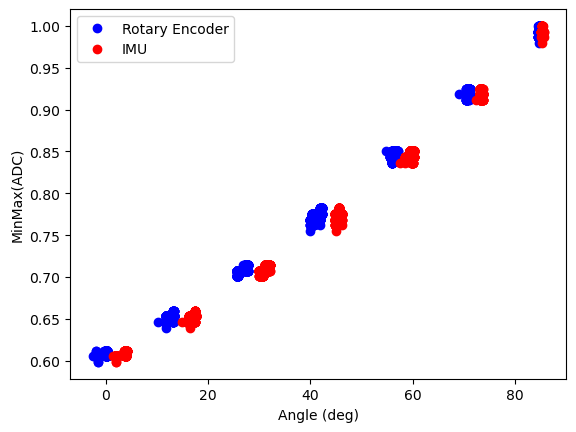

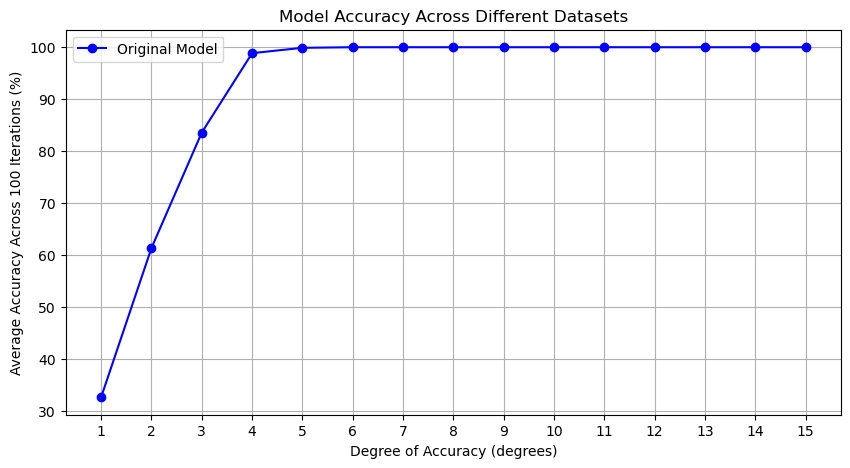

In [19]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_21_2024/1p5/*.csv"
g.read_data_2(path)


# Perform quadratic fit where 80% train/ 20% test, and determine accuracy to +/- 10 deg
accuracy = g.train_test(deg_accuracy=10)
print(accuracy)

# Plot the data with fitted results
g.plot_data()



# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# Across Samples

11/25/2024

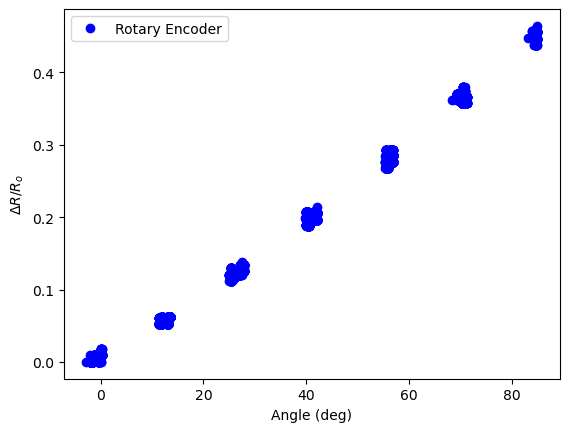

In [137]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/across_samples/*.csv"
g.read_data_norm(path)

g.plot_data()

# Compare abs_100 to abs 1p5 to get an idea of difference in sensitivity and model fitting

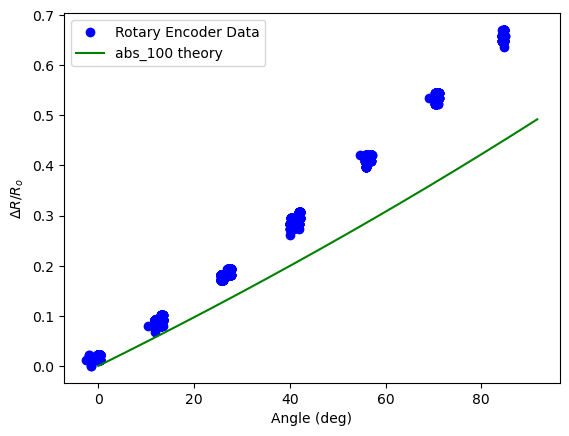

In [135]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_21_2024/1p5/*.csv"
g.read_data_norm(path)

g.model_data()




25884


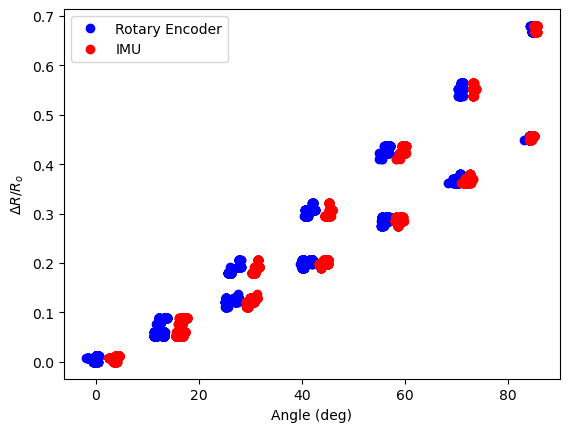

In [72]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/*.csv"
g.read_data_norm(path)

print(g.data.size)

# Plot the data with fitted results
g.plot_data()





# 11_27_2024  

abs_1p53_bubble  reapplication test 3 times

38940


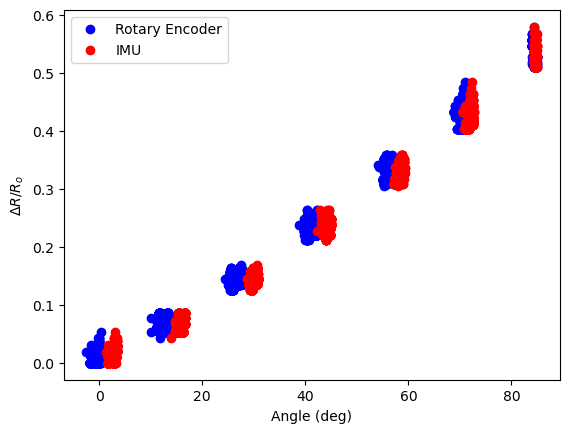

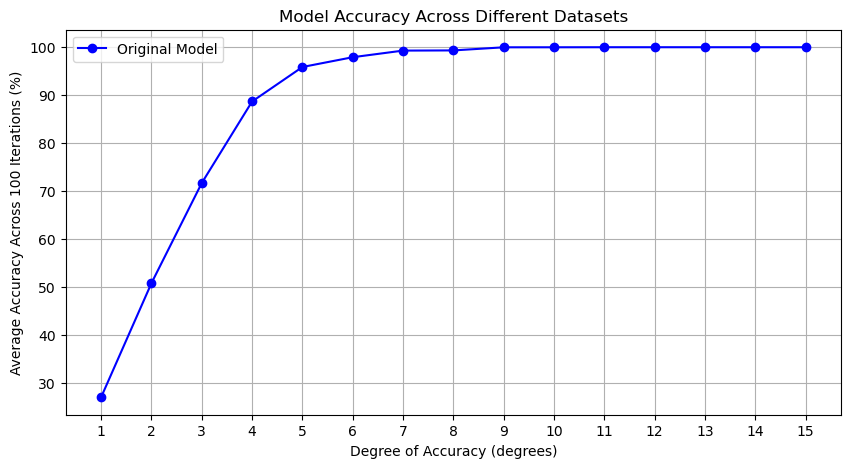

In [83]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_27_2024/1_53_bubble/*.csv"
g.read_data_norm(path)

print(g.data.size)

# Plot the data with fitted results
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# 12_2_2024 Angle testing

12916


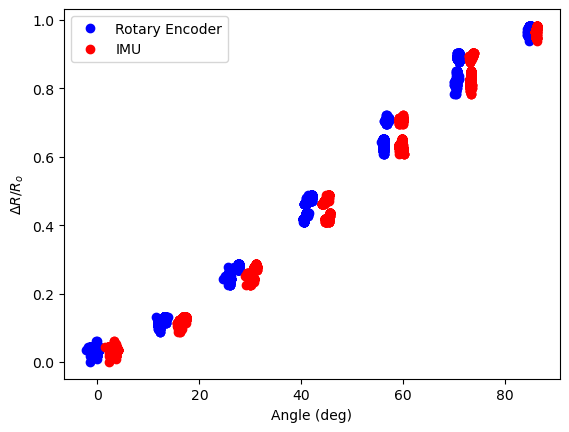

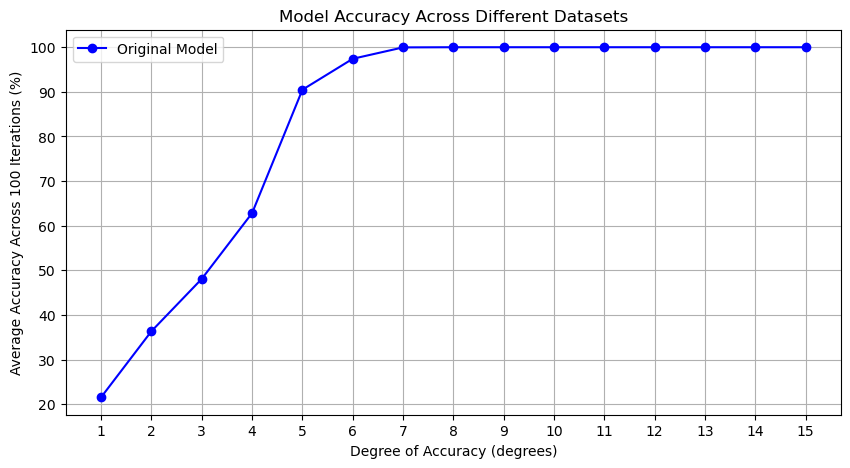

In [91]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_2_2024/0 deg/2nd trial/*.csv"
g.read_data_norm(path)

print(g.data.size)

# Plot the data with fitted results
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# 12/9/2024

Testing repeatability

116620


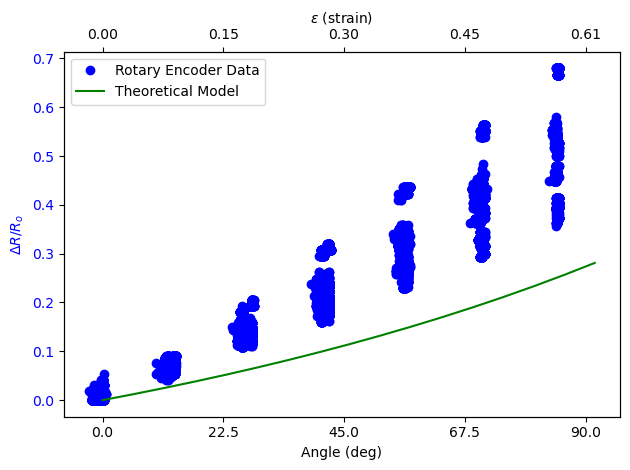

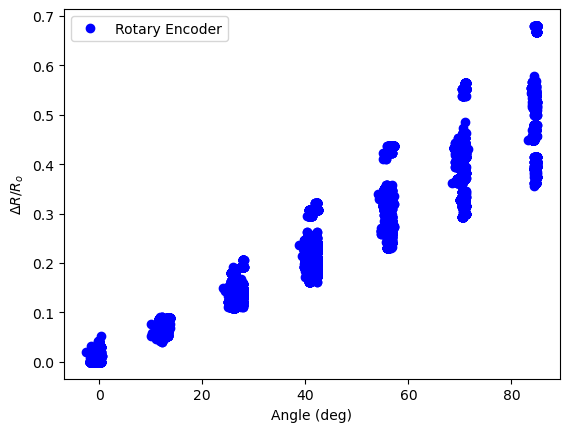

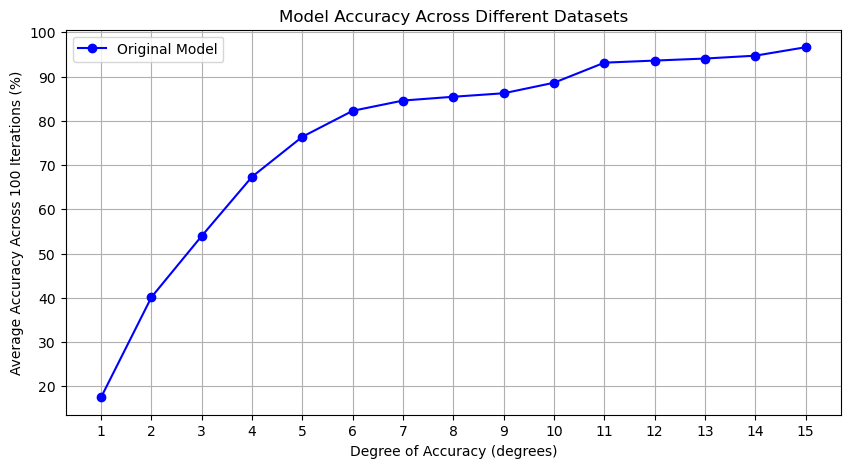

In [66]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

g = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/compare 1p8 to 1p5 and 2p3/*.csv"
g.read_data_norm(path)

print(g.data.size)

# Plot the data with fitted results
thick = 0.08 + 0.25 + 0.125
l_sam = 1.83
l_ch = 4.12 # length of newest channel
area = 0.0004
res = 0.5
g.model_data(thick, l_ch, l_sam, area, res)
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()

# 12/11/22

Comparing different lengths, thickness, etc experimentally

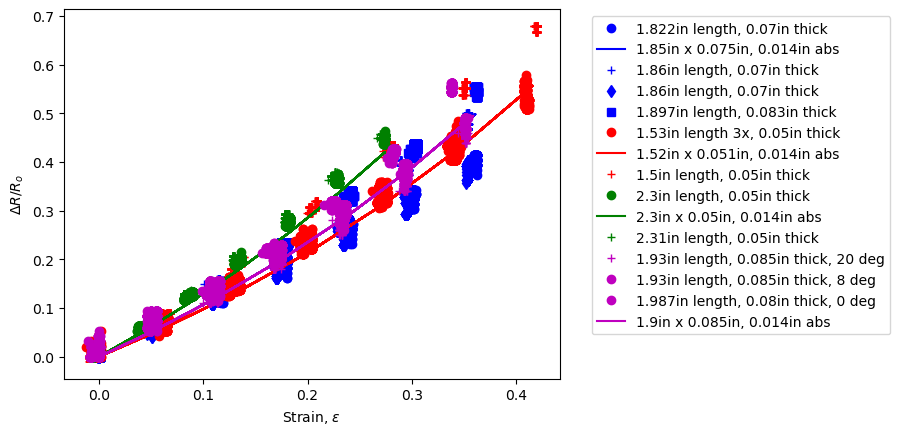

In [132]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize


# samples 1.8" or so in length

# abs_1p822

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/first/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.07 + 0.25 + 0.125
l_sam = 1.822
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'bo', label='1.822in length, 0.07in thick')  # Blue circles for Rotary Encoder

# plotting theoretical model of above data set

theta = -1*data.iloc[:, 3] * np.pi / 180  # Include 90 by adding increment
rho = 29.4 * 10**-8
thick = 0.075 + 0.25 + 0.125
l_sam = 1.85
area = 0.014*0.014
l_ch = 4.11
res = 0.5
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
dr = (rho * eps * (l_ch * 0.0254) * (8 - eps) / ((area * 0.000645) * (2 - eps)**2))
drrt = dr / res
plt.plot(eps, drrt, 'b', label='1.85in x 0.075in, 0.014in abs')


# abs_1p86_s2

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/second/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.07 + 0.25 + 0.125
l_sam = 1.86
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'b+', label='1.86in length, 0.07in thick')  # Blue circles for Rotary Encoder

# abs_1p86_s3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/third/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.07 + 0.25 + 0.125
l_sam = 1.86
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'bd', label='1.86in length, 0.07in thick')  # Blue circles for Rotary Encoder
   
# abs_1p897_s4

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/fourth/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.083 + 0.25 + 0.125
l_sam = 1.86
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'bs', label='1.897in length, 0.083in thick')  # Blue circles for Rotary Encoder

# abs_1p53 x 3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_27_2024/1_53_bubble/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.05 + 0.25 + 0.125
l_sam = 1.53
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'ro', label='1.53in length 3x, 0.05in thick')  # Blue circles for Rotary Encoder

# plotting theoretical model of above data set

theta = -1*data.iloc[:, 3] * np.pi / 180  # Include 90 by adding increment
rho = 29.4 * 10**-8
thick = 0.051 + 0.25 + 0.125
l_sam = 1.52
res = 0.5
l_ch = 3.75
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
dr = (rho * eps * (l_ch * 0.0254) * (8 - eps) / ((area * 0.000645) * (2 - eps)**2))
drrt = dr / res
plt.plot(eps, drrt, 'r', label='1.52in x 0.051in, 0.014in abs')

# abs_1p5

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/1p5/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.05 + 0.25 + 0.125
l_sam = 1.5
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'r+', label='1.5in length, 0.05in thick')  # Blue circles for Rotary Encoder


# abs_2p3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/2p3/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.05 + 0.25 + 0.125
l_sam = 2.3
l_ch = 5
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'go', label='2.3in length, 0.05in thick')  # Blue circles for Rotary Encoder

# plotting theoretical model of above data set

theta = -1*data.iloc[:, 3] * np.pi / 180  # Include 90 by adding increment
rho = 29.4 * 10**-8
thick = 0.05 + 0.25 + 0.125
l_sam = 2.3
res = 0.5
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
dr = (rho * eps * (l_ch * 0.0254) * (8 - eps) / ((area * 0.000645) * (2 - eps)**2))
drrt = dr / res
plt.plot(eps, drrt, 'g', label='2.3in x 0.05in, 0.014in abs')

# abs_2p31

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/2p31/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.05 + 0.25 + 0.125
l_sam = 2.31
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'g+', label='2.31in length, 0.05in thick')  # Blue circles for Rotary Encoder

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_12_2024/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.085 + 0.25 + 0.125
l_sam = 1.93
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'm+', label='1.93in length, 0.085in thick, 20 deg')  # Blue circles for Rotary Encoder

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_12_2024/8 deg/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.085 + 0.25 + 0.125
l_sam = 1.93
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'mo', label='1.93in length, 0.085in thick, 8 deg')  # Blue circles for Rotary Encoder

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/0 deg/*.csv"
data = a.read_data_norm(path)
n = data.shape[0]
thick = 0.08 + 0.25 + 0.125
l_sam = 1.987
theta = -1*data.iloc[:, 3] * np.pi / 180
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
plt.plot(eps, data.iloc[:, 2], 'mo', label='1.987in length, 0.08in thick, 0 deg')  # Blue circles for Rotary Encoder

# plotting theoretical model of above data set

theta = -1*data.iloc[:, 3] * np.pi / 180  # Include 90 by adding increment
rho = 29.4 * 10**-8
thick = 0.085 + 0.25 + 0.125
l_sam = 1.9
res = 0.5
l_ch = 4.11
eps = (thick * 0.0254) * theta / (l_sam * 0.0254)
dr = (rho * eps * (l_ch * 0.0254) * (8 - eps) / ((area * 0.000645) * (2 - eps)**2))
drrt = dr / res
plt.plot(eps, drrt, 'm', label='1.9in x 0.085in, 0.014in abs')


# Setting labels
plt.xlabel('Strain, $\epsilon$')
plt.ylabel('$\Delta R/R_o$')
# Adding legend
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()




# Min Max Scaler All


Found 11 CSV files.


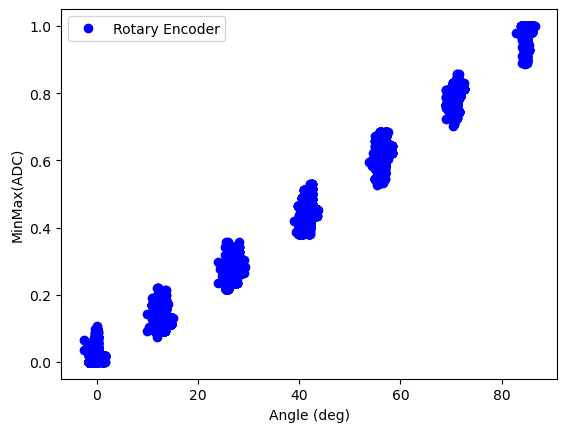

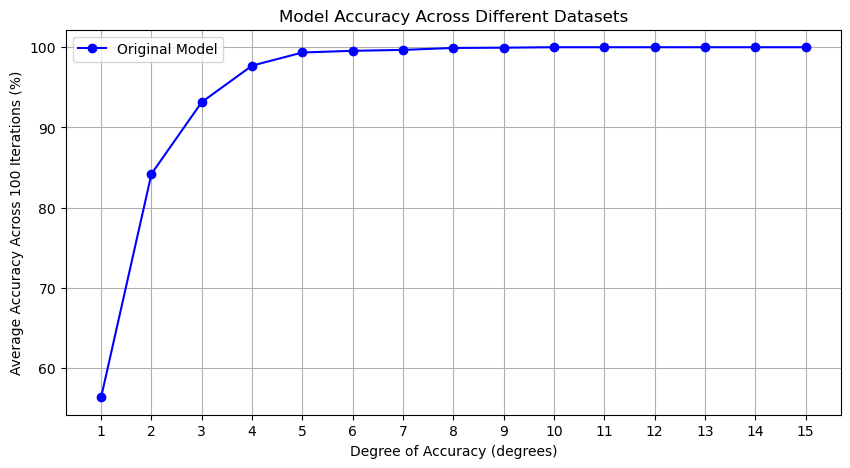

In [145]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/compare 1p8 to 1p5 and 2p3/*.csv"
a.read_data_2(path)
a.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()


# nor res vs bend angle color coded

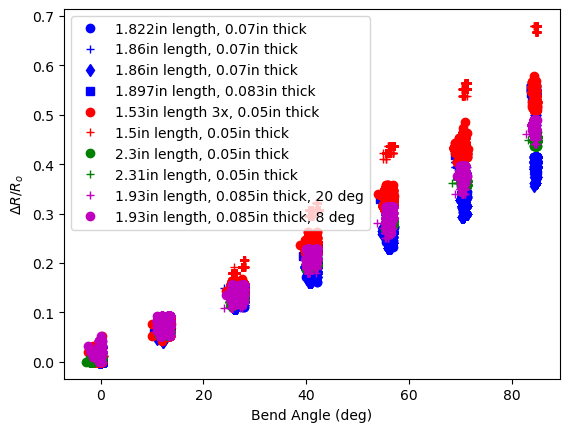

In [156]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize


# samples 1.8" or so in length

# abs_1p822

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/first/*.csv"
data = g.read_data_norm(path)

plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'bo', label='1.822in length, 0.07in thick')  # Blue circles for Rotary Encoder



# abs_1p86_s2

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/second/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'b+', label='1.86in length, 0.07in thick')  # Blue circles for Rotary Encoder

# abs_1p86_s3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/third/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'bd', label='1.86in length, 0.07in thick')  # Blue circles for Rotary Encoder
   
# abs_1p897_s4

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/fourth/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'bs', label='1.897in length, 0.083in thick')  # Blue circles for Rotary Encoder

# abs_1p53 x 3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_27_2024/1_53_bubble/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'ro', label='1.53in length 3x, 0.05in thick')  # Blue circles for Rotary Encoder

# abs_1p5

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/1p5/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'r+', label='1.5in length, 0.05in thick')  # Blue circles for Rotary Encoder


# abs_2p3

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/2p3/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'go', label='2.3in length, 0.05in thick')  # Blue circles for Rotary Encoder

# abs_2p31

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/11_25_24/reapply/2p31/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'g+', label='2.31in length, 0.05in thick')  # Blue circles for Rotary Encoder

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_12_2024/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'm+', label='1.93in length, 0.085in thick, 20 deg')  # Blue circles for Rotary Encoder

a = bender_class(data=pd.DataFrame())
#path contains 4 csv files
path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_12_2024/8 deg/*.csv"
data = a.read_data_norm(path)
plt.plot(-1*data.iloc[:, 3], data.iloc[:, 2], 'mo', label='1.93in length, 0.085in thick, 8 deg')  # Blue circles for Rotary Encoder
       


# Setting labels
plt.xlabel('Bend Angle (deg)')
plt.ylabel('$\Delta R/R_o$')
# Adding legend
plt.legend()
plt.show()

# 12/18/2024

 — within sensor repeatability for reapplication: train on one application, test on re-application, repeat for all sensors to get accuracy w/ error bar

In [42]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_2(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_2(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_fourth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fourth.append(np.mean(accuracies))




Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


In [47]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_fifth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fifth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_2(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_sixth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_sixth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_2(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_seventh = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fourth.append(np.mean(accuracies))




Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


In [53]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_eigth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_eigth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_s.read_data_2(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_ninth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_ninth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_2(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_tenth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_tenth.append(np.mean(accuracies))




Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


In [55]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_eleventh = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_eleventh.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_s.read_data_2(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_twelvth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_twelvth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_2(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_thirteenth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_thirteenth.append(np.mean(accuracies))




Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


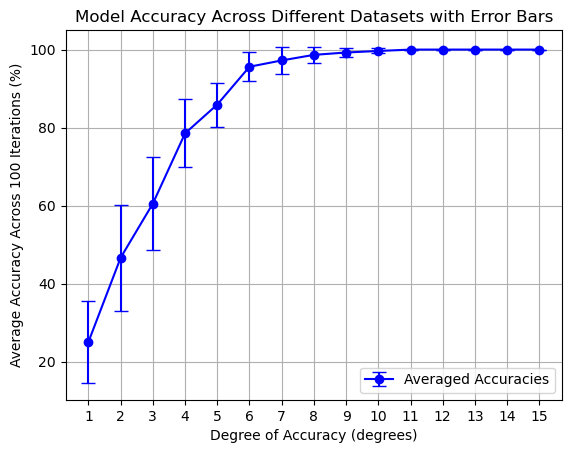

In [56]:
# Create a DataFrame with datasets as columns
df = pd.DataFrame({
    'Dataset1': all_accuracies_second,
    'Dataset2': all_accuracies_third,
    'Dataset3': all_accuracies_fourth,
    'Dataset4': all_accuracies_fifth,
    'Dataset5': all_accuracies_sixth,
    'Dataset6': all_accuracies_seventh,
    'Dataset7': all_accuracies_eigth,
    'Dataset8': all_accuracies_ninth,
    'Dataset9': all_accuracies_tenth,
    'Dataset7': all_accuracies_eleventh,
    'Dataset8': all_accuracies_twelvth,
    'Dataset9': all_accuracies_thirteenth,
})

# Compute the row-wise average
df['Average'] = df.mean(axis=1)
# Compute the row-wise stds
df['Standard Deviation'] = df.std(axis=1)


# Plot with error bars
plt.errorbar(
    degree_of_accuracies,           # x-axis values
    df['Average'],                  # y-axis values (averages)
    yerr=df['Standard Deviation'],  # Error bars (standard deviations)
    fmt='o-',                       # Line with circle markers
    capsize=5,                      # Cap size for error bars
    color='blue',                   # Line color
    label='Averaged Accuracies'
)

# Customize plot
plt.title('Model Accuracy Across Different Datasets with Error Bars')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()


# same as above plots except use read_data_norm to get norm change res over original res..above plot using MinMax

In [76]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
g.read_data_norm(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_g.read_data_norm(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_norm(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_norm(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_fourth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fourth.append(np.mean(accuracies))




In [77]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
g.read_data_norm(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_norm(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_fifth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fifth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_norm(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_sixth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_sixth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_norm(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_seventh = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_seventh.append(np.mean(accuracies))




In [78]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
g.read_data_norm(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_norm(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_eigth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_eigth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_s.read_data_norm(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_ninth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_ninth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
new_s.read_data_norm(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_tenth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_tenth.append(np.mean(accuracies))




In [79]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/fourth test/*.csv"
g.read_data_norm(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/first test/*.csv"
new_g.read_data_norm(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_eleventh = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_eleventh.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/second test/*.csv"
new_s.read_data_norm(path_3)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_twelvth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_twelvth.append(np.mean(accuracies))
    
# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_4 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/1_53_bubble_reapplication/third test/*.csv"
new_s.read_data_norm(path_4)  # Read the third dataset

# Initialize accuracies for the third dataset
all_accuracies_thirteenth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_thirteenth.append(np.mean(accuracies))




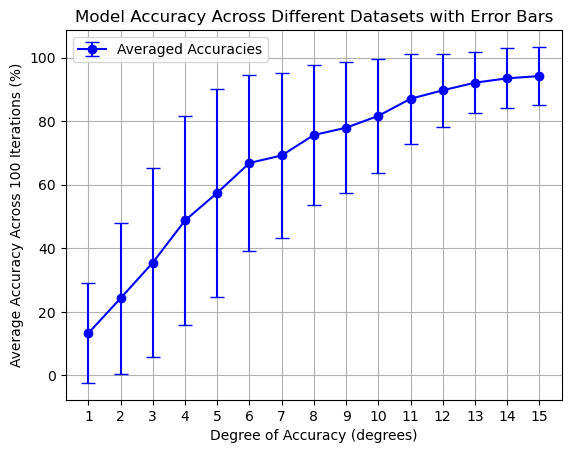

In [80]:
# Create a DataFrame with datasets as columns
df = pd.DataFrame({
    'Dataset1': all_accuracies_second,
    'Dataset2': all_accuracies_third,
    'Dataset3': all_accuracies_fourth,
    'Dataset4': all_accuracies_fifth,
    'Dataset5': all_accuracies_sixth,
    'Dataset6': all_accuracies_seventh,
    'Dataset7': all_accuracies_eigth,
    'Dataset8': all_accuracies_ninth,
    'Dataset9': all_accuracies_tenth,
    'Dataset7': all_accuracies_eleventh,
    'Dataset8': all_accuracies_twelvth,
    'Dataset9': all_accuracies_thirteenth,
})

# Compute the row-wise average
df['Average'] = df.mean(axis=1)
# Compute the row-wise stds
df['Standard Deviation'] = df.std(axis=1)


# Plot with error bars
plt.errorbar(
    degree_of_accuracies,           # x-axis values
    df['Average'],                  # y-axis values (averages)
    yerr=df['Standard Deviation'],  # Error bars (standard deviations)
    fmt='o-',                       # Line with circle markers
    capsize=5,                      # Cap size for error bars
    color='blue',                   # Line color
    label='Averaged Accuracies'
)

# Customize plot
plt.title('Model Accuracy Across Different Datasets with Error Bars')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()


# Testing for Misalignment

Found 1 CSV files.


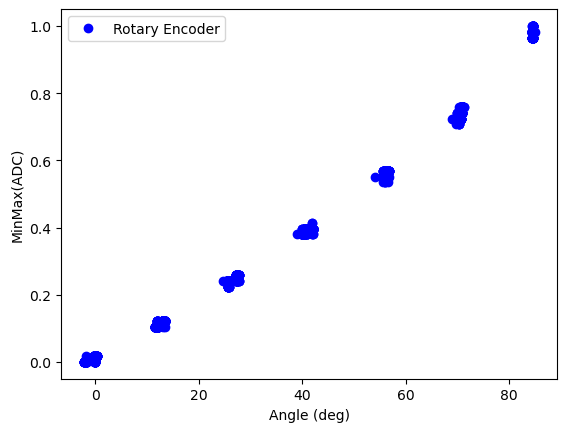

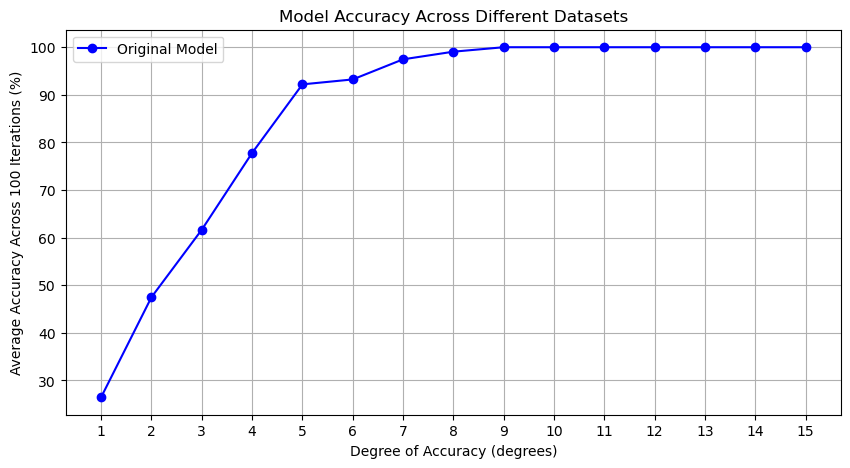

In [82]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/0 deg/*.csv"
g.read_data_2(path_1)
g.plot_data()

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))
    
# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(degree_of_accuracies, all_accuracies_first, marker='o', label='Original Model', color='blue')

# Customize plot
plt.title('Model Accuracy Across Different Datasets')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()


In [94]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/0 deg/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/8 deg/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_second = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_second.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/20 deg/*.csv"
new_s.read_data_2(path_3)  # Read the second dataset

# Initialize accuracies for the third dataset
all_accuracies_third = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_third.append(np.mean(accuracies))
   


Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


In [95]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/8 deg/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/0 deg/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_fourth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fourth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/20 deg/*.csv"
new_s.read_data_2(path_2)  # Read the second dataset
# Initialize accuracies for the third dataset
all_accuracies_fifth = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_fifth.append(np.mean(accuracies))
   


Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


In [96]:
# Initialize the first dataset
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/20 deg/*.csv"
g.read_data_2(path_1)

# Initialize parameters for accuracy calculation
degree_of_accuracies = list(range(15, 0, -1))  # From 10 to 1
all_accuracies_first = []

# Calculate average accuracy for the first dataset using train_test
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy = g.train_test(deg_accuracy=degree)  # Use train_test for the first dataset
        accuracies.append(accuracy)
    all_accuracies_first.append(np.mean(accuracies))

# Create another bender_class instance for the second dataset
new_g = bender_class(data=pd.DataFrame())
path_2 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/0 deg/*.csv"
new_g.read_data_2(path_2)  # Read the second dataset

# Initialize accuracies for the second dataset
all_accuracies_sixth = []

# Calculate average accuracy for the second dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_g, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_sixth.append(np.mean(accuracies))

# Create another bender_class instance for the third dataset
new_s = bender_class(data=pd.DataFrame())
path_3 =  "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/8 deg/*.csv"
new_s.read_data_2(path_2)  # Read the second dataset
# Initialize accuracies for the third dataset
all_accuracies_seventh = []

# Calculate average accuracy for the third dataset using predict_new_data
for degree in degree_of_accuracies:
    accuracies = []
    for _ in range(100):
        accuracy, _ = g.predict_new_data(new_s, deg_accuracy=degree)  # Use predict_new_data
        accuracies.append(accuracy)
    all_accuracies_seventh.append(np.mean(accuracies))
   


Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.


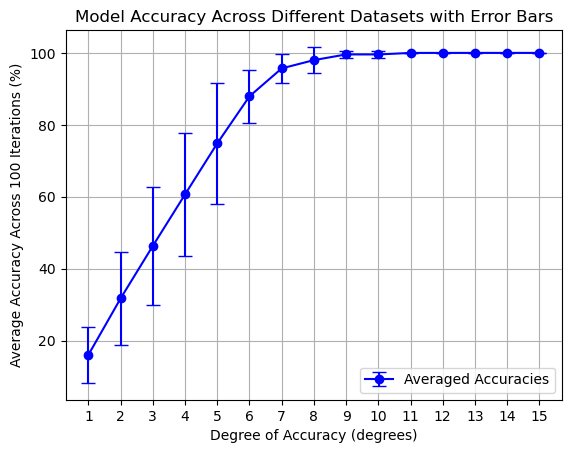

In [97]:
# Create a DataFrame with datasets as columns
df = pd.DataFrame({
    'Dataset1': all_accuracies_second,
    'Dataset2': all_accuracies_third,
    'Dataset3': all_accuracies_fourth,
    'Dataset4': all_accuracies_fifth,
    'Dataset5': all_accuracies_sixth,
    'Dataset6': all_accuracies_seventh,
})

# Compute the row-wise average
df['Average'] = df.mean(axis=1)
# Compute the row-wise stds
df['Standard Deviation'] = df.std(axis=1)


# Plot with error bars
plt.errorbar(
    degree_of_accuracies,           # x-axis values
    df['Average'],                  # y-axis values (averages)
    yerr=df['Standard Deviation'],  # Error bars (standard deviations)
    fmt='o-',                       # Line with circle markers
    capsize=5,                      # Cap size for error bars
    color='blue',                   # Line color
    label='Averaged Accuracies'
)

# Customize plot
plt.title('Model Accuracy Across Different Datasets with Error Bars')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()


# Dynamic Testing 100 cycles

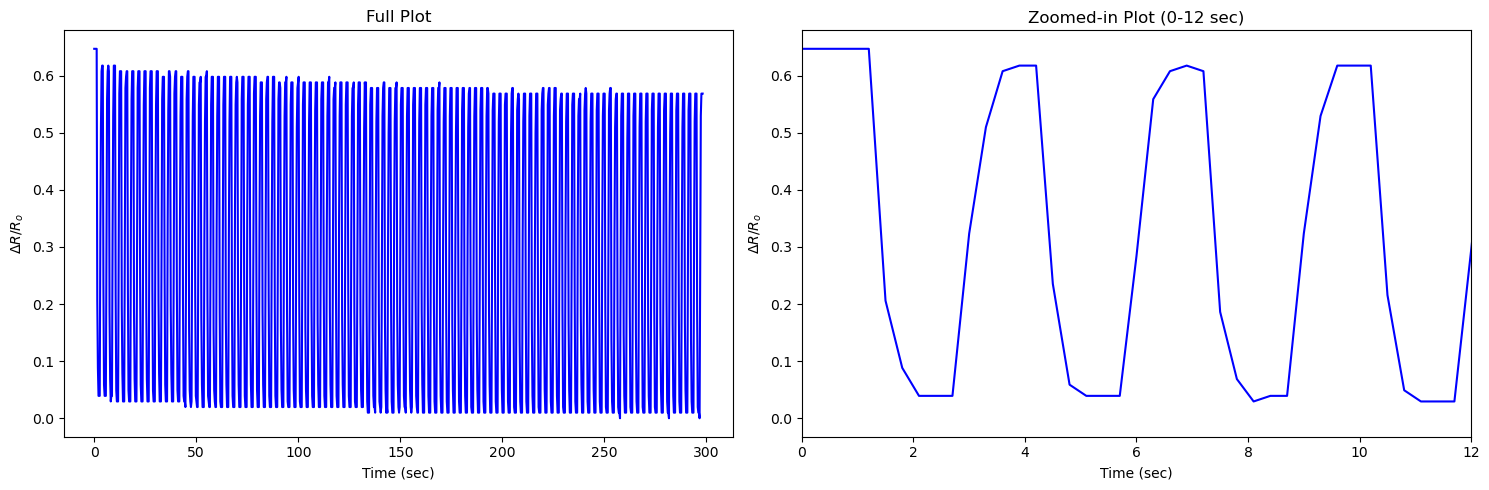

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/dynamic 100 cycles/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) * 0.3  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 2].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

 # Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the full range on the first subplot
ax[0].plot(x_data, y_data, 'b')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('$\Delta R/R_o$')
ax[0].set_title('Full Plot')

# Zoomed-in plot for time range between 0 and 4 seconds
ax[1].plot(x_data, y_data, 'b')
ax[1].set_xlim(0, 12)  # Set x-axis to zoom between 0 and 4 seconds
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('$\Delta R/R_o$')
ax[1].set_title('Zoomed-in Plot (0-12 sec)')

# Display the subplots
plt.tight_layout()  # Adjust the spacing
plt.show()


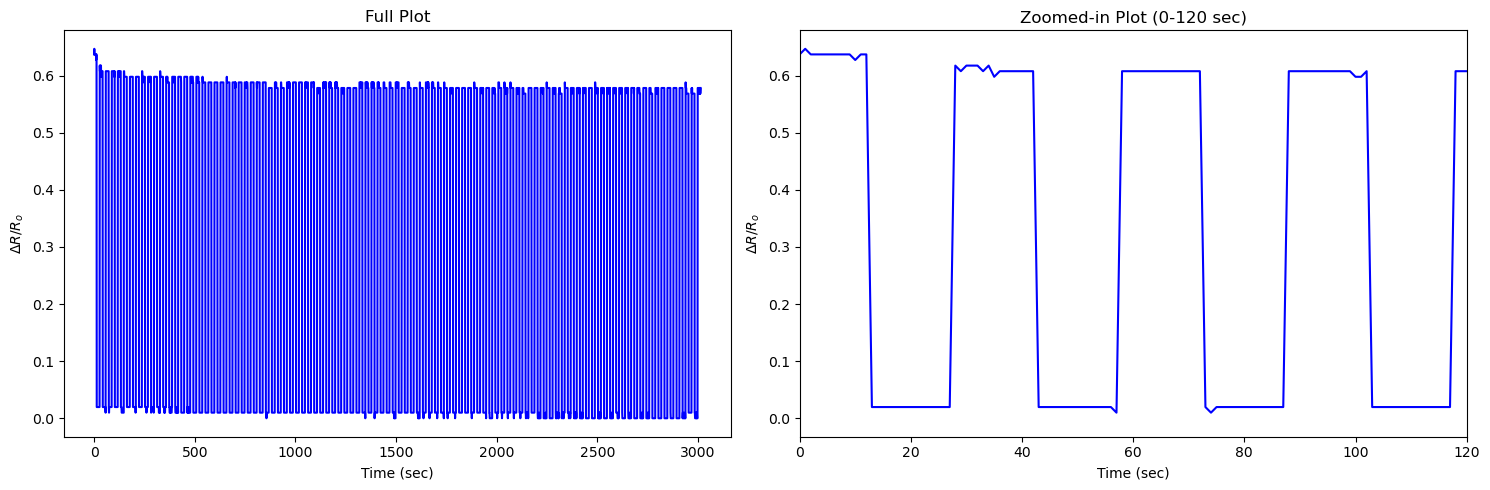

In [121]:
# 1 second delay before collecting 15 samples where above is 0.3 sec delay before collecting 5 samples

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/dynamic 100 cycles/v2_1sec/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) *1  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 2].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

 # Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the full range on the first subplot
ax[0].plot(x_data, y_data, 'b')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('$\Delta R/R_o$')
ax[0].set_title('Full Plot')

# Zoomed-in plot for time range between 0 and 4 seconds
ax[1].plot(x_data, y_data, 'b')
ax[1].set_xlim(0, 120)  # Set x-axis to zoom between 0 and 4 seconds
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('$\Delta R/R_o$')
ax[1].set_title('Zoomed-in Plot (0-120 sec)')

# Display the subplots
plt.tight_layout()  # Adjust the spacing
plt.show()

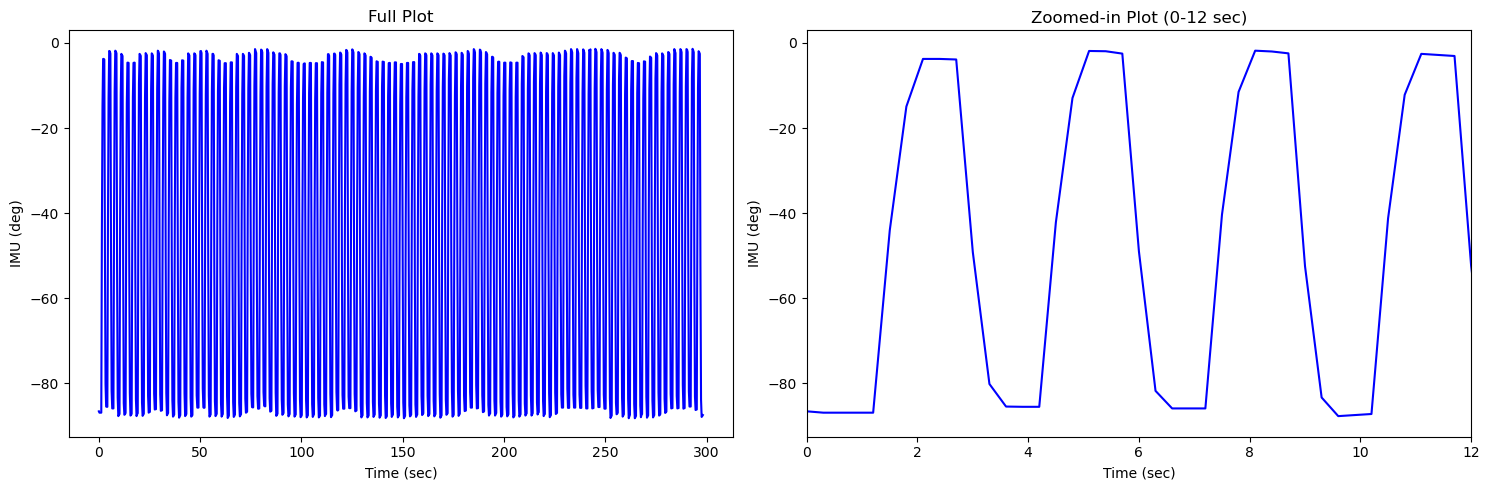

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/dynamic 100 cycles/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) * 0.3  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 1].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

 # Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the full range on the first subplot
ax[0].plot(x_data, y_data, 'b')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('IMU (deg)')
ax[0].set_title('Full Plot')

# Zoomed-in plot for time range between 0 and 4 seconds
ax[1].plot(x_data, y_data, 'b')
ax[1].set_xlim(0, 12)  # Set x-axis to zoom between 0 and 4 seconds
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('IMU (deg)')
ax[1].set_title('Zoomed-in Plot (0-12 sec)')

# Display the subplots
plt.tight_layout()  # Adjust the spacing
plt.show()


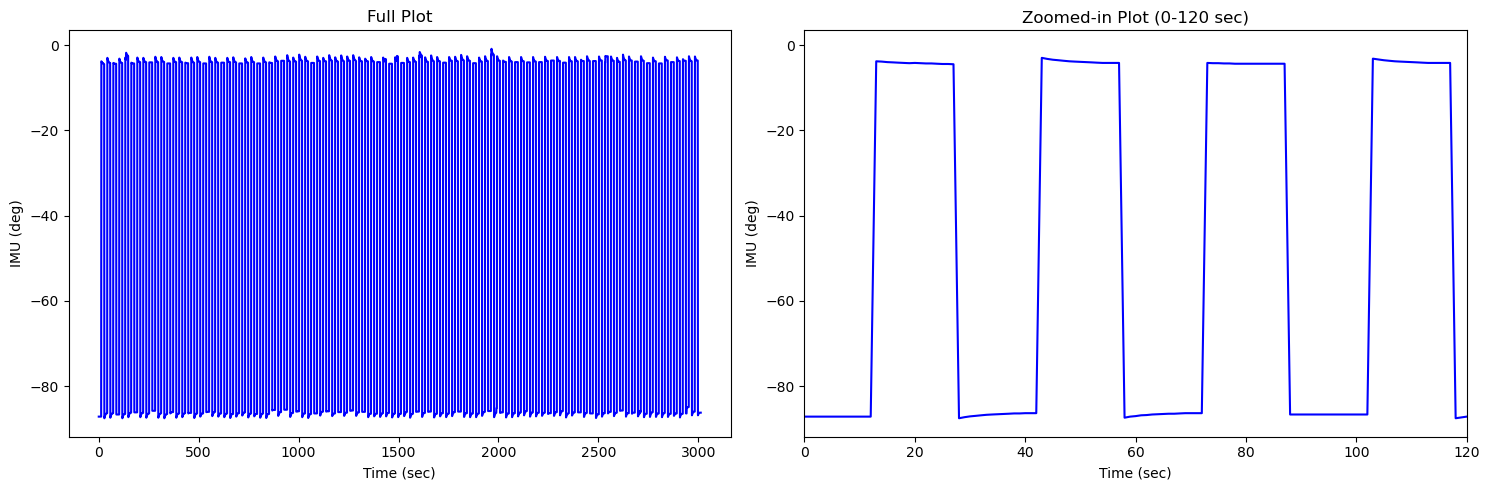

In [123]:
# 1 sec delay collect 15 samples 

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/dynamic 100 cycles/v2_1sec/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) * 1  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 1].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

 # Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the full range on the first subplot
ax[0].plot(x_data, y_data, 'b')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('IMU (deg)')
ax[0].set_title('Full Plot')

# Zoomed-in plot for time range between 0 and 4 seconds
ax[1].plot(x_data, y_data, 'b')
ax[1].set_xlim(0, 120)  # Set x-axis to zoom between 0 and 4 seconds
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('IMU (deg)')
ax[1].set_title('Zoomed-in Plot (0-120 sec)')

# Display the subplots
plt.tight_layout()  # Adjust the spacing
plt.show()

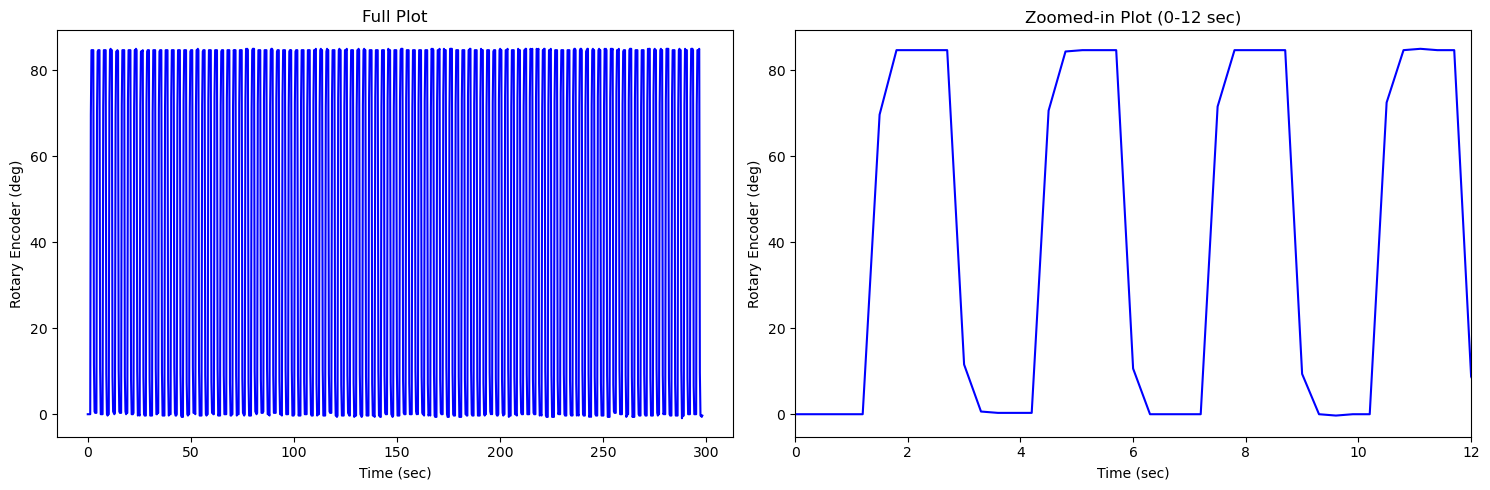

In [116]:
# now do rotary encoder

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/dynamic 100 cycles/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) * 0.3  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 3].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

 # Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot the full range on the first subplot
ax[0].plot(x_data, y_data, 'b')
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Rotary Encoder (deg)')
ax[0].set_title('Full Plot')

# Zoomed-in plot for time range between 0 and 4 seconds
ax[1].plot(x_data, y_data, 'b')
ax[1].set_xlim(0, 12)  # Set x-axis to zoom between 0 and 4 seconds
ax[1].set_xlabel('Time (sec)')
ax[1].set_ylabel('Rotary Encoder (deg)')
ax[1].set_title('Zoomed-in Plot (0-12 sec)')

# Display the subplots
plt.tight_layout()  # Adjust the spacing
plt.show()


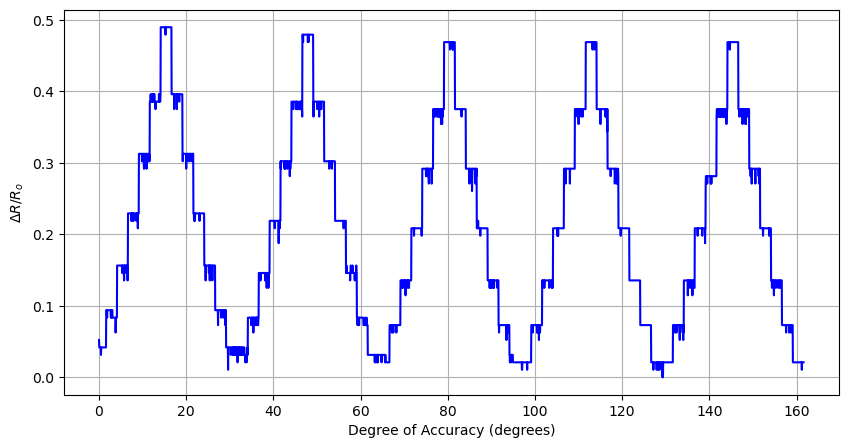

In [117]:
# now do rotary encoder

import matplotlib.pyplot as plt
import pandas as pd

# Assuming `g.read_data_norm(path_1)` populates `g.data`
g = bender_class(data=pd.DataFrame())
path_1 = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_18_2024/misalignment/8 deg/*.csv"
g.read_data_norm(path_1)

# Validate that `g.data` is populated

# Add timestamp column
num_rows = g.data.shape[0]  # Get the number of rows
timestamps = pd.Series(range(num_rows)) * 0.05  # 0.3 seconds (300 ms)
g.data['Timestamp'] = timestamps

# Ensure no mismatch in lengths
y_data = g.data.iloc[:, 2].dropna()  # Remove NaN values in the y-data
x_data = g.data['Timestamp'][:len(y_data)]  # Match the lengths of x and y

# Plot all accuracies on the same plot
plt.figure(figsize=(10, 5))
plt.plot(x_data, y_data, 'b')

# Customize plot
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('$\Delta R/R_o$')
plt.grid()


# Across Sensor Repeatability

In [126]:
import glob
import numpy as np
import pandas as pd

# Initialize degree of accuracies
degree_of_accuracies = list(range(15, 0, -1))  # From 15 to 1

# Path to the folder containing the CSV files
folder_path = "C:/Users/toppenheim/Desktop/UCSF/Preeya UCB/Strain-Sensor-/CSV Data/12_9_2024/compare 1p8 to 1p5 and 2p3/"
csv_files = glob.glob(f"{folder_path}*.csv")

# Dictionary to store accuracies for each train-test combination
all_results = {}

# Iterate through each CSV file to act as the train_test model
for train_file in csv_files:
    # Initialize the training instance
    train_instance = bender_class(data=pd.DataFrame())
    train_instance.read_data_2(train_file)  # Load the train_test model data

    # Train the model using `train_test` for the current train file
    train_accuracies = []
    for degree in degree_of_accuracies:
        degree_accuracies = []
        for _ in range(100):  # Train/test multiple times
            accuracy = train_instance.train_test(deg_accuracy=degree)
            degree_accuracies.append(accuracy)
        train_accuracies.append(np.mean(degree_accuracies))
    
    # Store train accuracies for the current file
    all_results[train_file] = {"train_accuracies": train_accuracies, "predict_accuracies": {}}

    # Iterate through all CSV files for predictions
    for predict_file in csv_files:
        if train_file == predict_file:
            # Skip the self-prediction case
            continue

        # Initialize the prediction instance
        predict_instance = bender_class(data=pd.DataFrame())
        predict_instance.read_data_2(predict_file)  # Load the prediction data

        # Calculate prediction accuracies using `predict_new_data`
        predict_accuracies = []
        for degree in degree_of_accuracies:
            degree_accuracies = []
            for _ in range(100):  # Predict multiple times
                accuracy, _ = train_instance.predict_new_data(predict_instance, deg_accuracy=degree)
                degree_accuracies.append(accuracy)
            predict_accuracies.append(np.mean(degree_accuracies))

        # Store prediction accuracies for the current predict file
        all_results[train_file]["predict_accuracies"][predict_file] = predict_accuracies




Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV files.
Found 1 CSV 

In [127]:
# Total number of training files
total_train_files = len(all_results)
print(f"Total Training Files: {total_train_files}")

# Total number of prediction lists
total_prediction_lists = sum(
    len(train_data["predict_accuracies"]) for train_data in all_results.values()
)
print(f"Total Prediction Accuracy Lists: {total_prediction_lists}")

Total Training Files: 12
Total Prediction Accuracy Lists: 132


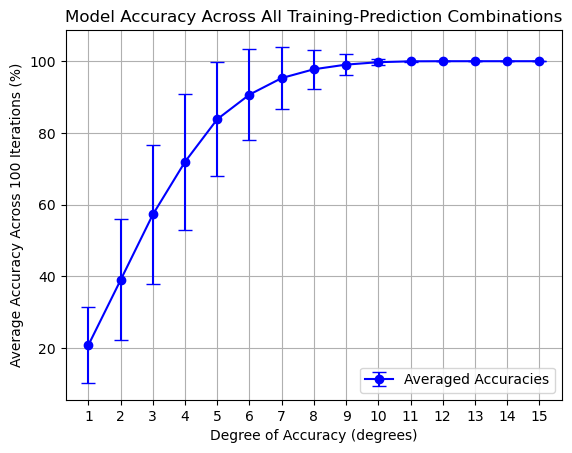

In [128]:
# Flatten all accuracies into a dictionary for creating a DataFrame
accuracy_data = {}
counter = 1  # Column index counter

for train_file, train_data in all_results.items():
    for predict_file, accuracies in train_data["predict_accuracies"].items():
        column_name = f"Train: {train_file}, Predict: {predict_file}"
        accuracy_data[column_name] = accuracies
        counter += 1

# Create the DataFrame from the accuracy data
df = pd.DataFrame(accuracy_data)

# Compute the row-wise average
df['Average'] = df.mean(axis=1)

# Compute the row-wise standard deviation
df['Standard Deviation'] = df.std(axis=1)

import matplotlib.pyplot as plt

# Plot with error bars
plt.errorbar(
    degree_of_accuracies,           # x-axis values
    df['Average'],                  # y-axis values (averages)
    yerr=df['Standard Deviation'],  # Error bars (standard deviations)
    fmt='o-',                       # Line with circle markers
    capsize=5,                      # Cap size for error bars
    color='blue',                   # Line color
    label='Averaged Accuracies'
)

# Customize plot
plt.title('Model Accuracy Across All Training-Prediction Combinations')
plt.xlabel('Degree of Accuracy (degrees)')
plt.ylabel('Average Accuracy Across 100 Iterations (%)')
plt.xticks(degree_of_accuracies)  # Set x-ticks to correspond to degrees
plt.legend()  # Add legend to differentiate datasets
plt.grid()
plt.show()


# 12/19/2024

Run the 0 deg 1.93 sample to check peak norm res and compare to 100 cycle peak